# Clustering evaluation on high dimensional data

The goal of this notebook is to provide a basic template walkthrough of obtaining and preparing a number of (simple) high dimensional datasets that can reasonably used to clustering evaluation. The datasets chosen have associated class labels that *should* be meaningful in terms of how the data clusters, and thus we can use label based clustering evaluation such as ARI and AMI to determine how well different clustering approaches are performing.

The primary purpose of this notebook is to provide a set of baseline datasets that clustering algorithm developers can try their algorithms out on. Performing reasinably well on these datasets is a necessary but not sufficient condition of a good clustering algorithm.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src import paths
data_folder = paths['data_path']

In [3]:
from sklearn.datasets import fetch_openml
from sklearn.datasets import load_digits
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, silhouette_score
from sklearn.decomposition import PCA
from sklearn import cluster

import numpy as np
import pandas as pd
import requests
import zipfile
import imageio
import os
from PIL import Image
from glob import glob
import re
import rarfile

import matplotlib.pyplot as plt
import seaborn as sns

import hdbscan
import umap
from sklearn.neighbors import KNeighborsTransformer
import pynndescent

import networkx as nx
import cdlib.algorithms as cd

sns.set()

2022-11-24 14:50:52,882 - utils - INFO - NumExpr defaulting to 4 threads.


Note: to be able to use all crisp methods, you need to install some additional packages:  {'karateclub', 'infomap', 'wurlitzer', 'graph_tool'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'karateclub', 'ASLPAw'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'infomap', 'wurlitzer'}


# MNIST, USPS and Pendigits are easy

We can use the sklearn API to fetch data for the Pendigits, MNIST and USPS datasets.

Of these datasets pendigits is the smallest, with only 1797 samples, and is only 64 dimensional. This makes a good first dataset to test things out on -- the dataset is small enough that practically anything should be able to run on this efficiently.

USPS provides a slightly more challenging dataset, with almost 10,000 samples and 256 dimensions, but is still samall enough to be tractable for even naive clustering implementations.

MNIST provides a good basic scaling test with 70,000 samples in 784 dimensions. In practice this is not a very large dataset compared to many that people want to cluster, although the dimensionality may provide some challenges.

In [4]:
digits = load_digits()
mnist = fetch_openml("MNIST_784")
usps = fetch_openml("USPS")

# Buildings and COIL are harder

The buildings and COIL-20 datasets provide some slightly more challenging image based problems, with more complex images to be dealt with. Both are still small in number of samples, so should be easily tractable. COIL *should* be relatively easy to cluster since the different classes should provide fairly tight and distinct clusters (being 72 images of the same object from different angles for each class). The buildings dataset, which has colour images from many angles and different lighting conditions, should be a much more challenging problem to cluster if using simple euclidean distance on the flattened vectors.

In [5]:
if not os.path.isdir(data_folder):
    bashCommand = f"mkdir {data_folder}"
    os.system(bashCommand)

### COIL-20

In [6]:
%%time
if not os.path.isfile(data_folder / 'coil20.zip'):
    results = requests.get('http://www.cs.columbia.edu/CAVE/databases/SLAM_coil-20_coil-100/coil-20/coil-20-proc.zip')
    with open(data_folder / 'coil20.zip', "wb") as code:
        code.write(results.content)

CPU times: user 121 µs, sys: 55 µs, total: 176 µs
Wall time: 157 µs


In [7]:
images_zip = zipfile.ZipFile(data_folder / 'coil20.zip')
mylist = images_zip.namelist()
r = re.compile(".*\.png$")
filelist = list(filter(r.match, mylist))
images_zip.extractall(str(data_folder) + '/.')

In [8]:
%%time
coil_feature_vectors = []
for filename in filelist:
    im = imageio.imread(data_folder / filename)
    coil_feature_vectors.append(im.flatten())
coil_20_data = np.asarray(coil_feature_vectors)
coil_20_target = pd.Series(filelist).str.extract("obj([0-9]+)", expand=False).values.astype(np.int32)

CPU times: user 1.38 s, sys: 226 ms, total: 1.61 s
Wall time: 1.71 s


## Buildings

In [9]:
if not os.path.isfile(data_folder / 'buildings.rar'):
    results = requests.get('http://eprints.lincoln.ac.uk/id/eprint/16079/1/dataset.rar')
    with open(data_folder / 'buildings.rar', "wb") as code:
        code.write(results.content)

In [10]:
if not os.path.isfile(data_folder / 'sheffield_buildings/Dataset/Dataset/1/S1-01.jpeg'):
    rf = rarfile.RarFile(f'{data_folder}/buildings.rar')
    rf.extractall(f'{data_folder}/sheffield_buildings')

In [11]:
buildings_data = []
buildings_target = []
for i in range(1, 41):
    directory = data_folder / f"sheffield_buildings/Dataset/{i}"
    images = np.vstack([np.asarray(Image.open(filename).resize((96, 96))).flatten() for filename in glob(f"{directory}/*")])
    labels = np.full(len(glob(f"{directory}/*")), i, dtype=np.int32)
    buildings_data.append(images)
    buildings_target.append(labels)
buildings_data = np.vstack(buildings_data)
buildings_target = np.hstack(buildings_target)

# Clustering metric eval

To make things easier later we will write some short functions to evaluate clusterings (with some special handling of singleton clusters or noise points for clusterign algorithms that support such things), and to plot the results for easy comparison.

In [12]:
def eval_clusters(cluster_labels, true_labels, raw_data, cluster_method="None", min_cluster_size=5):
    unique_labels = np.unique(cluster_labels)
    cluster_sizes, size_ids = np.histogram(cluster_labels, bins=unique_labels)
    if np.any(cluster_sizes == 1): # Has singleton clusters -- call them noise
        singleton_clusters = size_ids[:-1][cluster_sizes <= min_cluster_size]
        for c in singleton_clusters:
            cluster_labels[cluster_labels == c] = -1
    if np.any(cluster_labels < 0): # Has noise points
        clustered_points = (cluster_labels >= 0)
        ari = adjusted_rand_score(true_labels[clustered_points], cluster_labels[clustered_points])
        ami = adjusted_mutual_info_score(true_labels[clustered_points], cluster_labels[clustered_points])
        sil = silhouette_score(raw_data[clustered_points], cluster_labels[clustered_points])
        pct_clustered = (np.sum(clustered_points) / cluster_labels.shape[0])
        print(f"ARI: {ari:.4f}\nAMI: {ami:.4f}\nSilhouette: {sil:.4f}\nPct clustered: {pct_clustered * 100:.2f}%")
    else:
        ari = adjusted_rand_score(true_labels, cluster_labels)
        ami = adjusted_mutual_info_score(true_labels, cluster_labels)
        sil = silhouette_score(raw_data, cluster_labels)
        print(f"ARI: {ari:.4f}\nAMI: {ami:.4f}\nSilhouette: {sil:.4f}")
        pct_clustered = 1.0
    
    return {"Method": cluster_method, "ARI": ari, "AMI": ami, "Silhouette": sil, "Pct Clustered": pct_clustered}

In [13]:
def plot_scores(results_dataframe, score_types=("ARI", "AMI"), colors=list(sns.color_palette()), width=0.75):
    fig, axs = plt.subplots(1, len(score_types), figsize=(8 * len(score_types), 8))
    x_ticklabels = results_dataframe.Method.unique()
    x_positions = np.arange(len(x_ticklabels), dtype=np.float32) - width / 2
    dim_red_types = results_dataframe["Dim Reduction"].unique()
    bar_width = width / len(dim_red_types)
    for offset_idx, dim_red in enumerate(dim_red_types):
        color = colors[offset_idx]
        for i, score_type in enumerate(score_types):
            sub_dataframe = results_dataframe[
                (results_dataframe["Score Type"] == score_type) &
                (results_dataframe["Dim Reduction"] == dim_red)
            ]
            axs[i].bar(
                x=x_positions,
                height=sub_dataframe["Score"],
                width=bar_width,
                align="edge",
                color=[(*color, v) for v in sub_dataframe["Pct Clustered"]],
                label=dim_red if i ==0 else None,
            )
            axs[i].set_xlabel("Cluster Method")
            axs[i].set_xticks(np.arange(len(x_ticklabels)))
            axs[i].set_xticklabels(x_ticklabels)
            axs[i].set_ylabel(f"{score_type} Score")
            axs[i].set_title(score_type, fontsize=20)
            axs[i].grid(visible=False, axis="x")
            axs[i].set_ylim([0, 1.05])
        x_positions += bar_width
        
    if len(dim_red_types) > 1:
        fig.legend(loc="center right", bbox_to_anchor=(1.125, 0.5), borderaxespad=0.0, fontsize=20)
        
    fig.tight_layout()

# Pendigits clustering scores

In [14]:
raw_pendigits = digits.data.astype(np.float32)

In [15]:
%%time
km_labels = cluster.KMeans(n_clusters=10).fit_predict(raw_pendigits)
cl_labels = cluster.AgglomerativeClustering(n_clusters=10, linkage="complete").fit_predict(raw_pendigits)
sl_labels = cluster.AgglomerativeClustering(n_clusters=160, linkage="single").fit_predict(raw_pendigits)
db_labels = cluster.DBSCAN(eps=20.0).fit_predict(raw_pendigits)
hd_labels = hdbscan.HDBSCAN(min_samples=5, min_cluster_size=100).fit_predict(raw_pendigits)

CPU times: user 1.59 s, sys: 106 ms, total: 1.7 s
Wall time: 918 ms


In [16]:
pendigits_raw_results = pd.DataFrame(
    [
        eval_clusters(km_labels, digits.target, raw_pendigits, cluster_method="K-Means"),
        eval_clusters(cl_labels, digits.target, raw_pendigits, cluster_method="Complete\nLinkage"),
        eval_clusters(sl_labels, digits.target, raw_pendigits, cluster_method="Single\nLinkage"),
        eval_clusters(db_labels, digits.target, raw_pendigits, cluster_method="DBSCAN"),
        eval_clusters(hd_labels, digits.target, raw_pendigits, cluster_method="HDBSCAN"),
    ]
)
pendigits_raw_results_long = pendigits_raw_results.melt(["Method", "Pct Clustered"], var_name="Score Type", value_name="Score")
pendigits_raw_results_long["Dim Reduction"] = "None"

ARI: 0.6647
AMI: 0.7375
Silhouette: 0.1821
ARI: 0.4287
AMI: 0.6092
Silhouette: 0.1193
ARI: 0.5700
AMI: 0.8105
Silhouette: 0.0833
Pct clustered: 90.37%
ARI: 0.8633
AMI: 0.8990
Silhouette: 0.1927
Pct clustered: 74.18%
ARI: 0.3165
AMI: 0.7092
Silhouette: 0.1121
Pct clustered: 80.69%


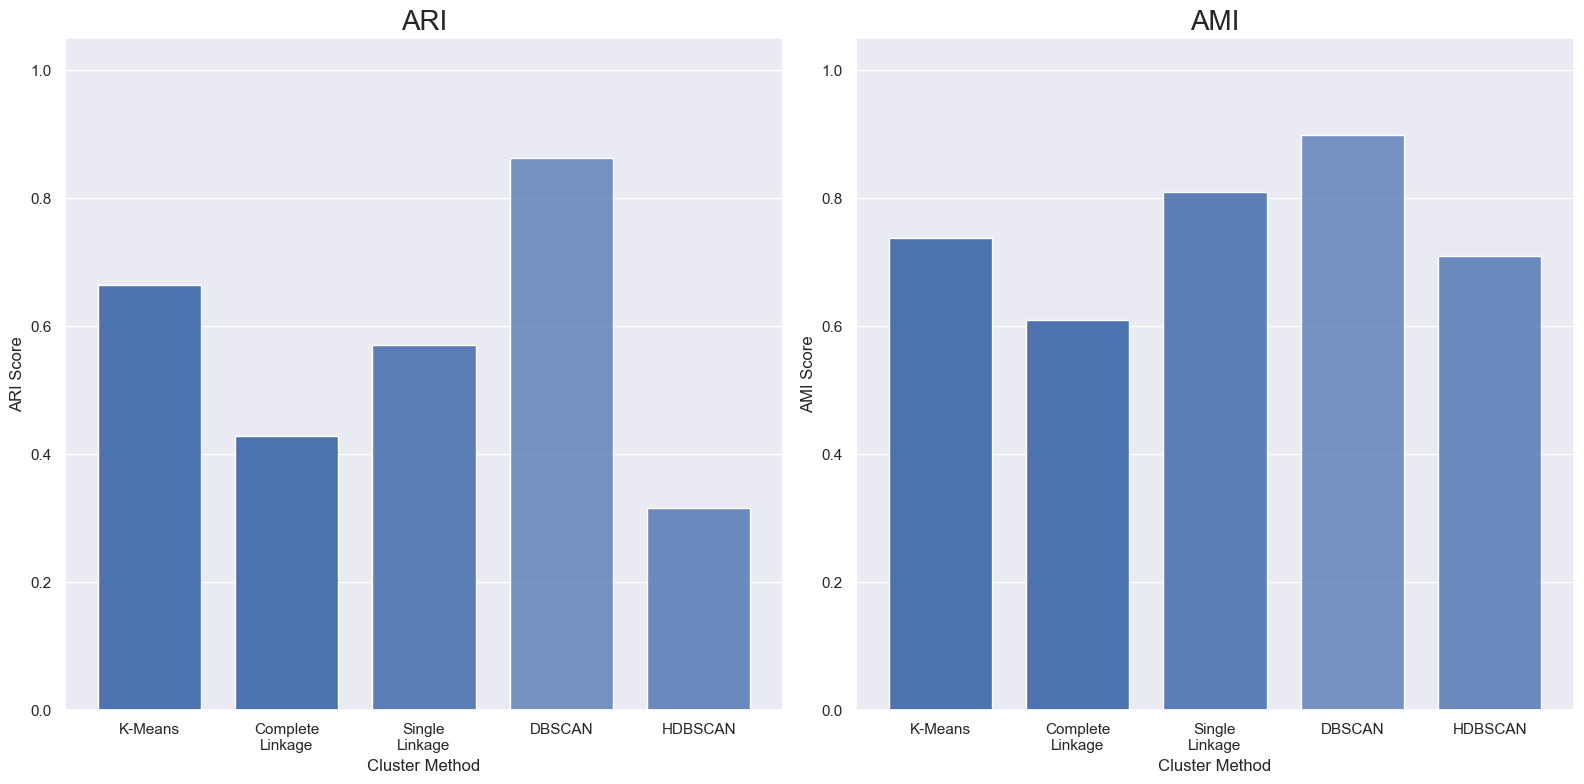

In [17]:
plot_scores(pendigits_raw_results_long)

In [18]:
pca_pendigits = PCA(n_components=16).fit_transform(raw_pendigits)

In [19]:
%%time
km_pca_labels = cluster.KMeans(n_clusters=10).fit_predict(pca_pendigits)
cl_pca_labels = cluster.AgglomerativeClustering(n_clusters=10, linkage="complete").fit_predict(pca_pendigits)
sl_pca_labels = cluster.AgglomerativeClustering(n_clusters=160, linkage="single").fit_predict(pca_pendigits)
db_pca_labels = cluster.DBSCAN(eps=15.0).fit_predict(pca_pendigits)
hd_pca_labels = hdbscan.HDBSCAN(min_samples=5, min_cluster_size=100).fit_predict(pca_pendigits)

CPU times: user 1.13 s, sys: 98.7 ms, total: 1.23 s
Wall time: 699 ms


In [20]:
pendigits_pca_results = pd.DataFrame(
    [
        eval_clusters(km_pca_labels, digits.target, raw_pendigits, cluster_method="K-Means"),
        eval_clusters(cl_pca_labels, digits.target, raw_pendigits, cluster_method="Complete\nLinkage"),
        eval_clusters(sl_pca_labels, digits.target, raw_pendigits, cluster_method="Single\nLinkage"),
        eval_clusters(db_pca_labels, digits.target, raw_pendigits, cluster_method="DBSCAN"),
        eval_clusters(hd_pca_labels, digits.target, raw_pendigits, cluster_method="HDBSCAN"),
    ]
)
pendigits_pca_results_long = pendigits_pca_results.melt(["Method", "Pct Clustered"], var_name="Score Type", value_name="Score")
pendigits_pca_results_long["Dim Reduction"] = "PCA"

ARI: 0.6617
AMI: 0.7352
Silhouette: 0.1820
ARI: 0.3802
AMI: 0.5739
Silhouette: 0.0957
ARI: 0.5199
AMI: 0.7980
Silhouette: 0.0873
Pct clustered: 89.32%
ARI: 0.8323
AMI: 0.8979
Silhouette: 0.1374
Pct clustered: 78.24%
ARI: 0.8808
AMI: 0.9400
Silhouette: 0.2066
Pct clustered: 72.73%


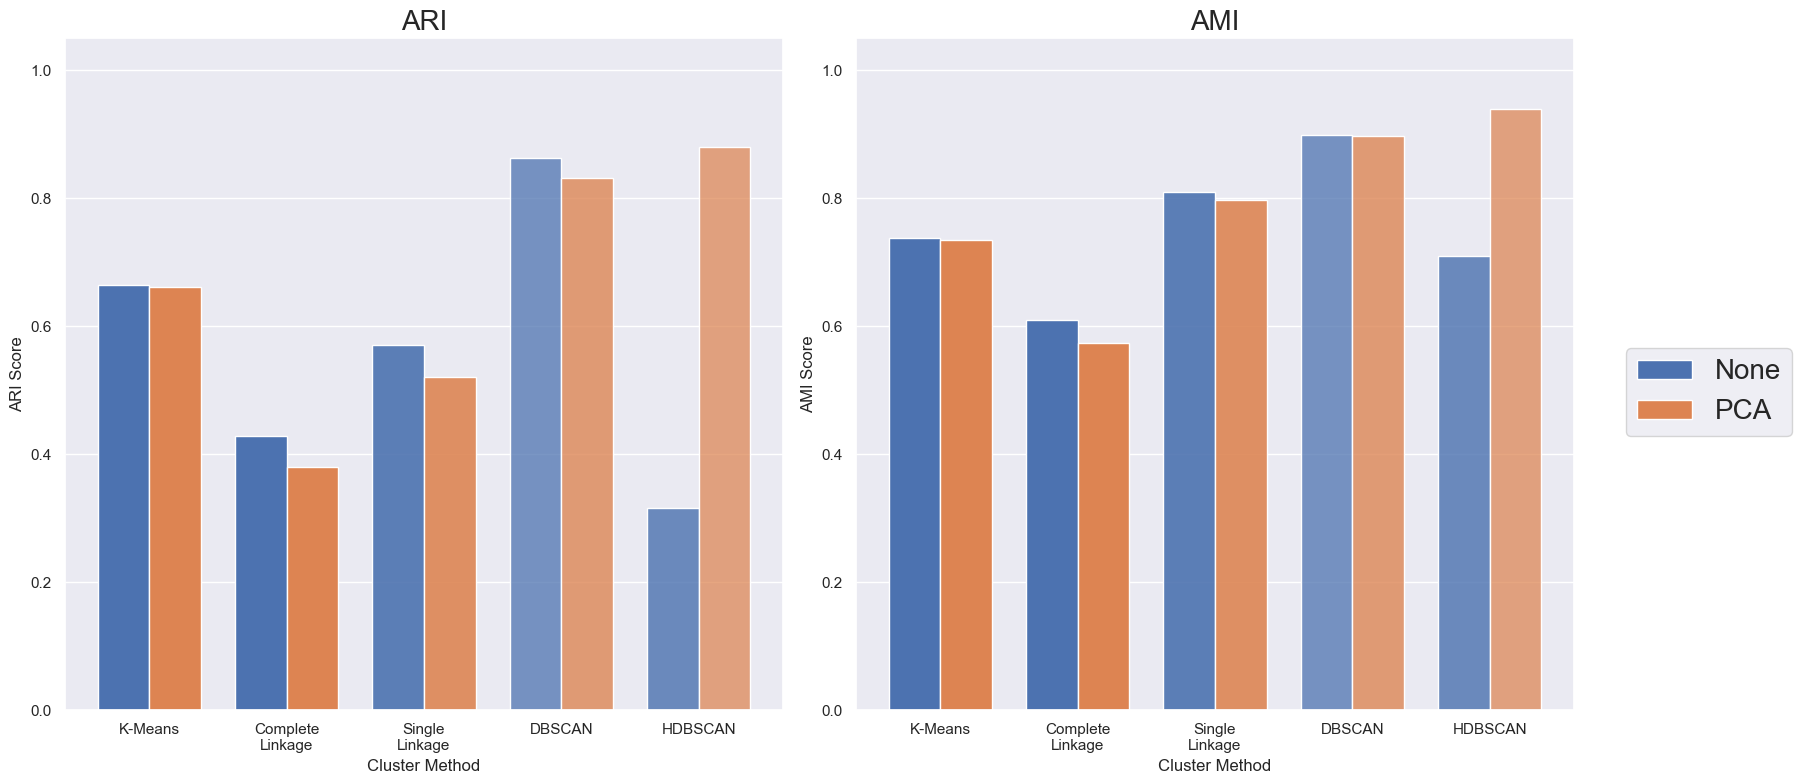

In [21]:
plot_scores(pd.concat([pendigits_raw_results_long, pendigits_pca_results_long]))

In [22]:
umap_pendigits = umap.UMAP(n_components=4, min_dist=1e-8, random_state=0).fit_transform(raw_pendigits)

In [23]:
%%time
km_umap_labels = cluster.KMeans(n_clusters=10).fit_predict(umap_pendigits)
cl_umap_labels = cluster.AgglomerativeClustering(n_clusters=10, linkage="complete").fit_predict(umap_pendigits)
sl_umap_labels = cluster.AgglomerativeClustering(n_clusters=20, linkage="single").fit_predict(umap_pendigits)
db_umap_labels = cluster.DBSCAN(eps=0.5).fit_predict(umap_pendigits)
hd_umap_labels = hdbscan.HDBSCAN(min_samples=5, min_cluster_size=100).fit_predict(umap_pendigits)

CPU times: user 992 ms, sys: 47.7 ms, total: 1.04 s
Wall time: 298 ms


In [24]:
pendigits_umap_results = pd.DataFrame(
    [
        eval_clusters(km_umap_labels, digits.target, raw_pendigits, cluster_method="K-Means"),
        eval_clusters(cl_umap_labels, digits.target, raw_pendigits, cluster_method="Complete\nLinkage"),
        eval_clusters(sl_umap_labels, digits.target, raw_pendigits, cluster_method="Single\nLinkage"),
        eval_clusters(db_umap_labels, digits.target, raw_pendigits, cluster_method="DBSCAN"),
        eval_clusters(hd_umap_labels, digits.target, raw_pendigits, cluster_method="HDBSCAN"),
    ]
)
pendigits_umap_results_long = pendigits_umap_results.melt(["Method", "Pct Clustered"], var_name="Score Type", value_name="Score")
pendigits_umap_results_long["Dim Reduction"] = "UMAP"

ARI: 0.8213
AMI: 0.9030
Silhouette: 0.1602
ARI: 0.8359
AMI: 0.9036
Silhouette: 0.1727
ARI: 0.8931
AMI: 0.9190
Silhouette: 0.1451
Pct clustered: 99.94%
ARI: 0.9208
AMI: 0.9346
Silhouette: 0.1544
ARI: 0.9487
AMI: 0.9527
Silhouette: 0.1717
Pct clustered: 97.38%


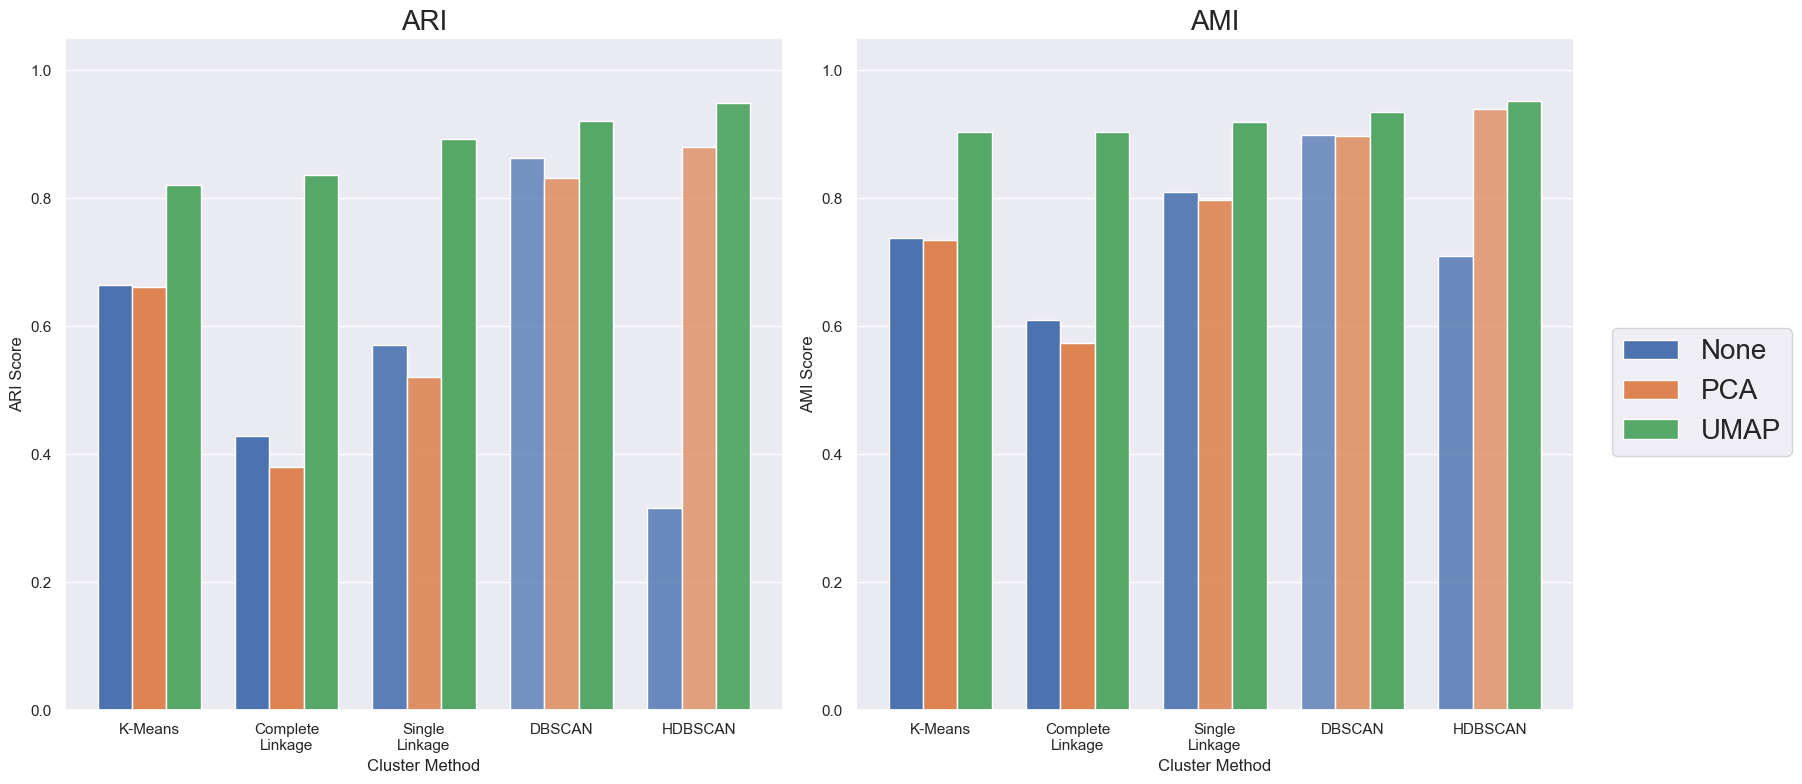

In [25]:
plot_scores(pd.concat([pendigits_raw_results_long, pendigits_pca_results_long, pendigits_umap_results_long]))

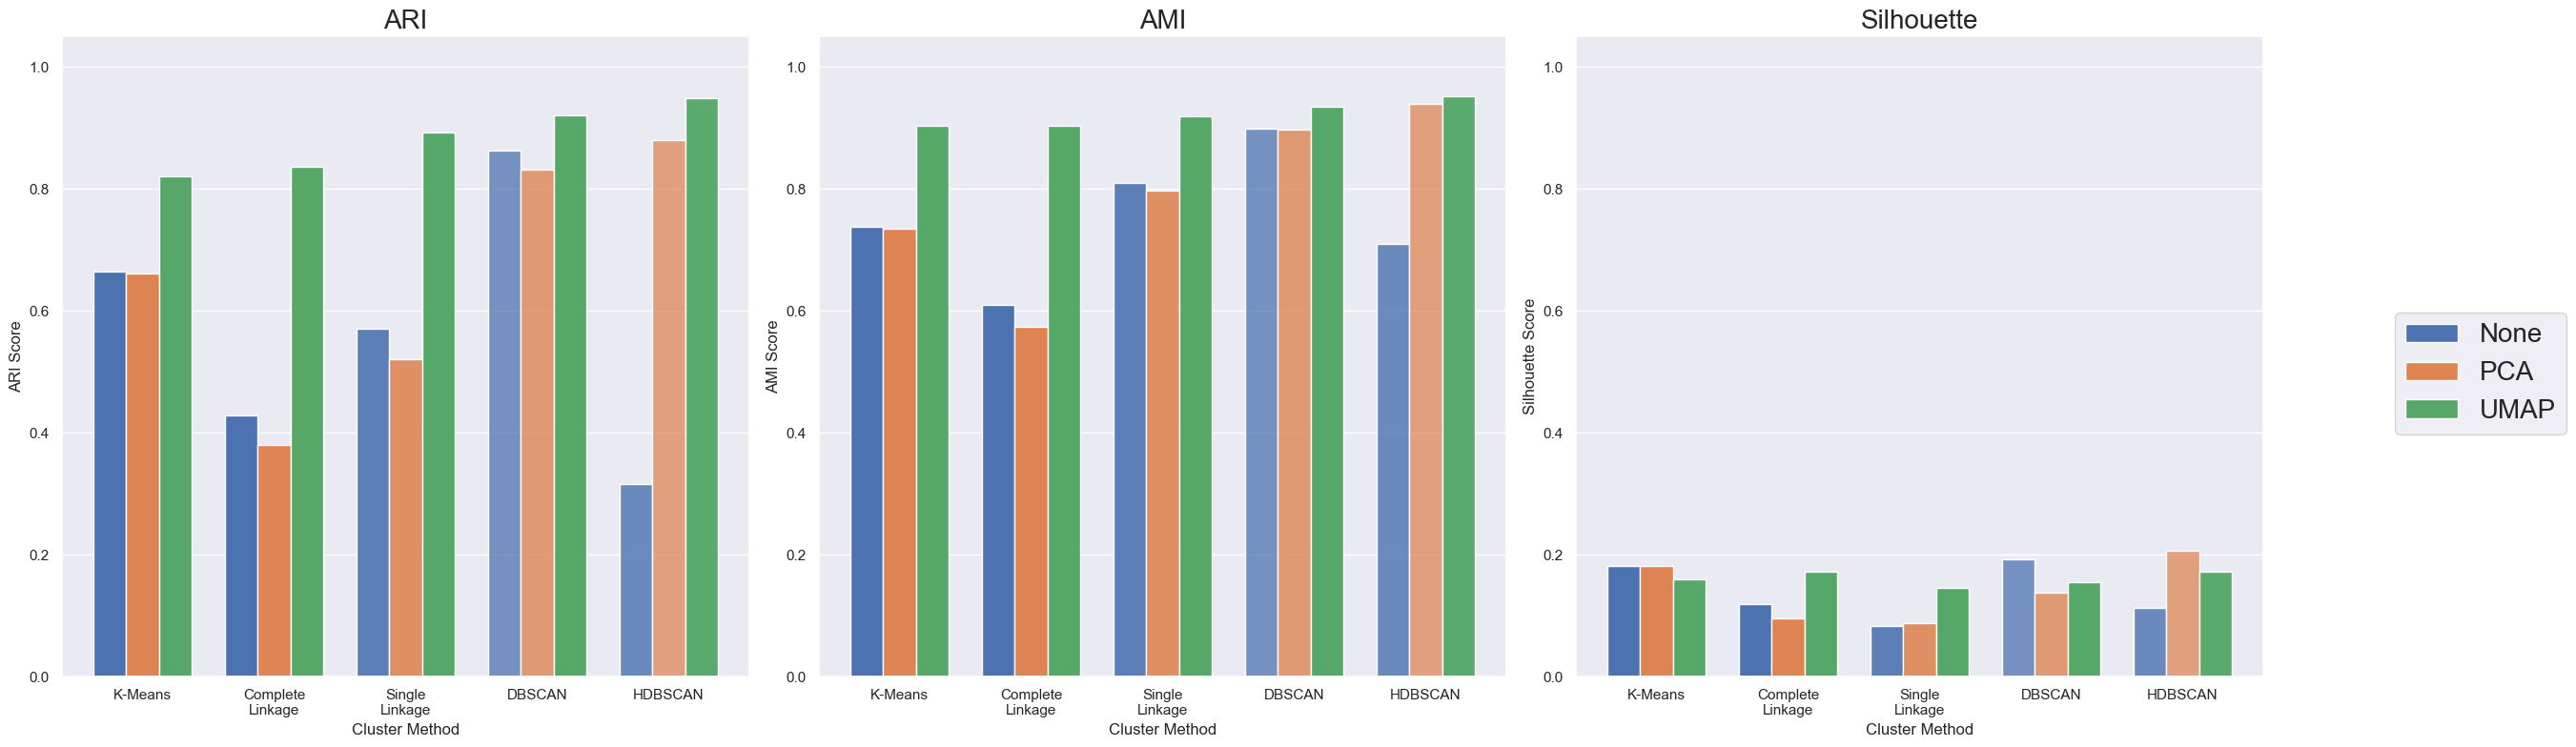

In [26]:
plot_scores(pd.concat([pendigits_raw_results_long, pendigits_pca_results_long, pendigits_umap_results_long]), 
            score_types=("ARI", "AMI", "Silhouette"))

# COIL-20 Clustering

In [27]:
raw_coil = coil_20_data.astype(np.float32)

In [28]:
%%time
km_labels = cluster.KMeans(n_clusters=20).fit_predict(raw_coil)

CPU times: user 50.5 s, sys: 4.67 s, total: 55.1 s
Wall time: 29.3 s


In [29]:
%%time
cl_labels = cluster.AgglomerativeClustering(n_clusters=20, linkage="complete").fit_predict(raw_coil)

CPU times: user 14.9 s, sys: 242 ms, total: 15.1 s
Wall time: 16 s


In [30]:
%%time
sl_labels = cluster.AgglomerativeClustering(n_clusters=80, linkage="single").fit_predict(raw_coil)

CPU times: user 20.5 s, sys: 347 ms, total: 20.9 s
Wall time: 22.9 s


In [31]:
%%time
db_labels = cluster.DBSCAN(eps=5000.0).fit_predict(raw_coil)

CPU times: user 3.16 s, sys: 245 ms, total: 3.41 s
Wall time: 4.15 s


In [32]:
np.unique(db_labels)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21])

In [33]:
%%time
hd_labels = hdbscan.HDBSCAN(min_samples=3, min_cluster_size=20).fit_predict(raw_coil)

CPU times: user 1min 8s, sys: 1.33 s, total: 1min 10s
Wall time: 1min 27s


In [34]:
coil_raw_results = pd.DataFrame(
    [
        eval_clusters(km_labels, coil_20_target, raw_coil, cluster_method="K-Means"),
        eval_clusters(cl_labels, coil_20_target, raw_coil, cluster_method="Complete\nLinkage"),
        eval_clusters(sl_labels, coil_20_target, raw_coil, cluster_method="Single\nLinkage"),
        eval_clusters(db_labels, coil_20_target, raw_coil, cluster_method="DBSCAN"),
        eval_clusters(hd_labels, coil_20_target, raw_coil, cluster_method="HDBSCAN"),
    ]
)
coil_raw_results_long = coil_raw_results.melt(["Method", "Pct Clustered"], var_name="Score Type", value_name="Score")
coil_raw_results_long["Dim Reduction"] = "None"

ARI: 0.6354
AMI: 0.7962
Silhouette: 0.2184
ARI: 0.3198
AMI: 0.6212
Silhouette: 0.1567
ARI: 0.5900
AMI: 0.8890
Silhouette: 0.0987
Pct clustered: 94.93%
ARI: 0.8971
AMI: 0.9545
Silhouette: 0.2508
Pct clustered: 78.68%
ARI: 0.8792
AMI: 0.9585
Silhouette: 0.2143
Pct clustered: 92.29%


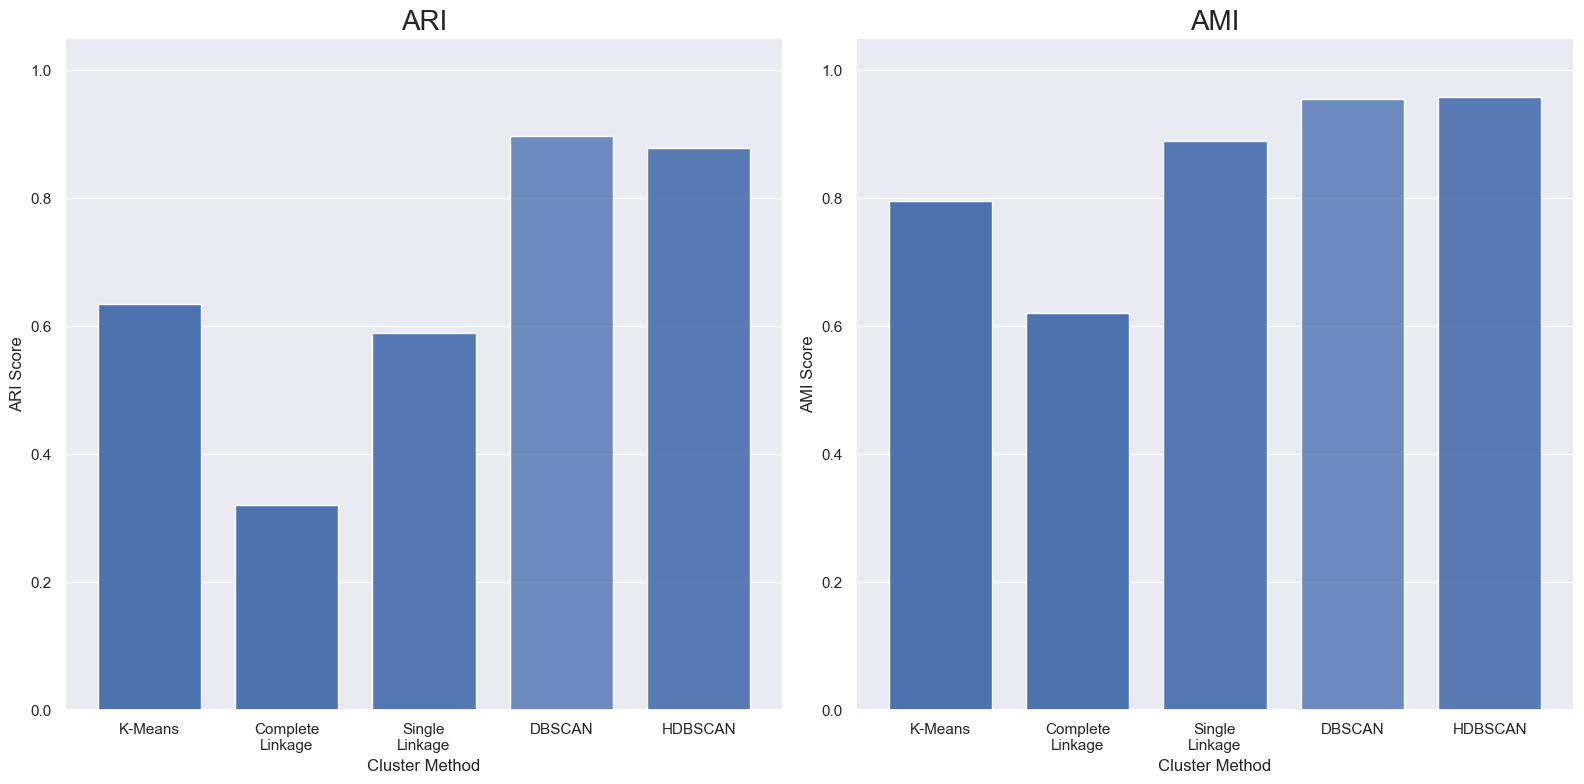

In [35]:
plot_scores(coil_raw_results_long)

In [36]:
pca_coil = PCA(n_components=64).fit_transform(raw_coil)

In [37]:
%%time
km_pca_labels = cluster.KMeans(n_clusters=20).fit_predict(pca_coil)
cl_pca_labels = cluster.AgglomerativeClustering(n_clusters=20, linkage="complete").fit_predict(pca_coil)
sl_pca_labels = cluster.AgglomerativeClustering(n_clusters=80, linkage="single").fit_predict(pca_coil)
db_pca_labels = cluster.DBSCAN(eps=4000.0).fit_predict(pca_coil)
hd_pca_labels = hdbscan.HDBSCAN(min_samples=3, min_cluster_size=20).fit_predict(pca_coil)

CPU times: user 1.71 s, sys: 106 ms, total: 1.82 s
Wall time: 925 ms


In [38]:
coil_pca_results = pd.DataFrame(
    [
        eval_clusters(km_pca_labels, coil_20_target, raw_coil, cluster_method="K-Means"),
        eval_clusters(cl_pca_labels, coil_20_target, raw_coil, cluster_method="Complete\nLinkage"),
        eval_clusters(sl_pca_labels, coil_20_target, raw_coil, cluster_method="Single\nLinkage"),
        eval_clusters(db_pca_labels, coil_20_target, raw_coil, cluster_method="DBSCAN"),
        eval_clusters(hd_pca_labels, coil_20_target, raw_coil, cluster_method="HDBSCAN"),
    ]
)
coil_pca_results_long = coil_pca_results.melt(["Method", "Pct Clustered"], var_name="Score Type", value_name="Score")
coil_pca_results_long["Dim Reduction"] = "PCA"

ARI: 0.6388
AMI: 0.7876
Silhouette: 0.2172
ARI: 0.3257
AMI: 0.6379
Silhouette: 0.1902
ARI: 0.8507
AMI: 0.9611
Silhouette: 0.1641
Pct clustered: 94.65%
ARI: 0.8822
AMI: 0.9640
Silhouette: 0.2119
Pct clustered: 92.64%
ARI: 0.8690
AMI: 0.9602
Silhouette: 0.1903
Pct clustered: 95.69%


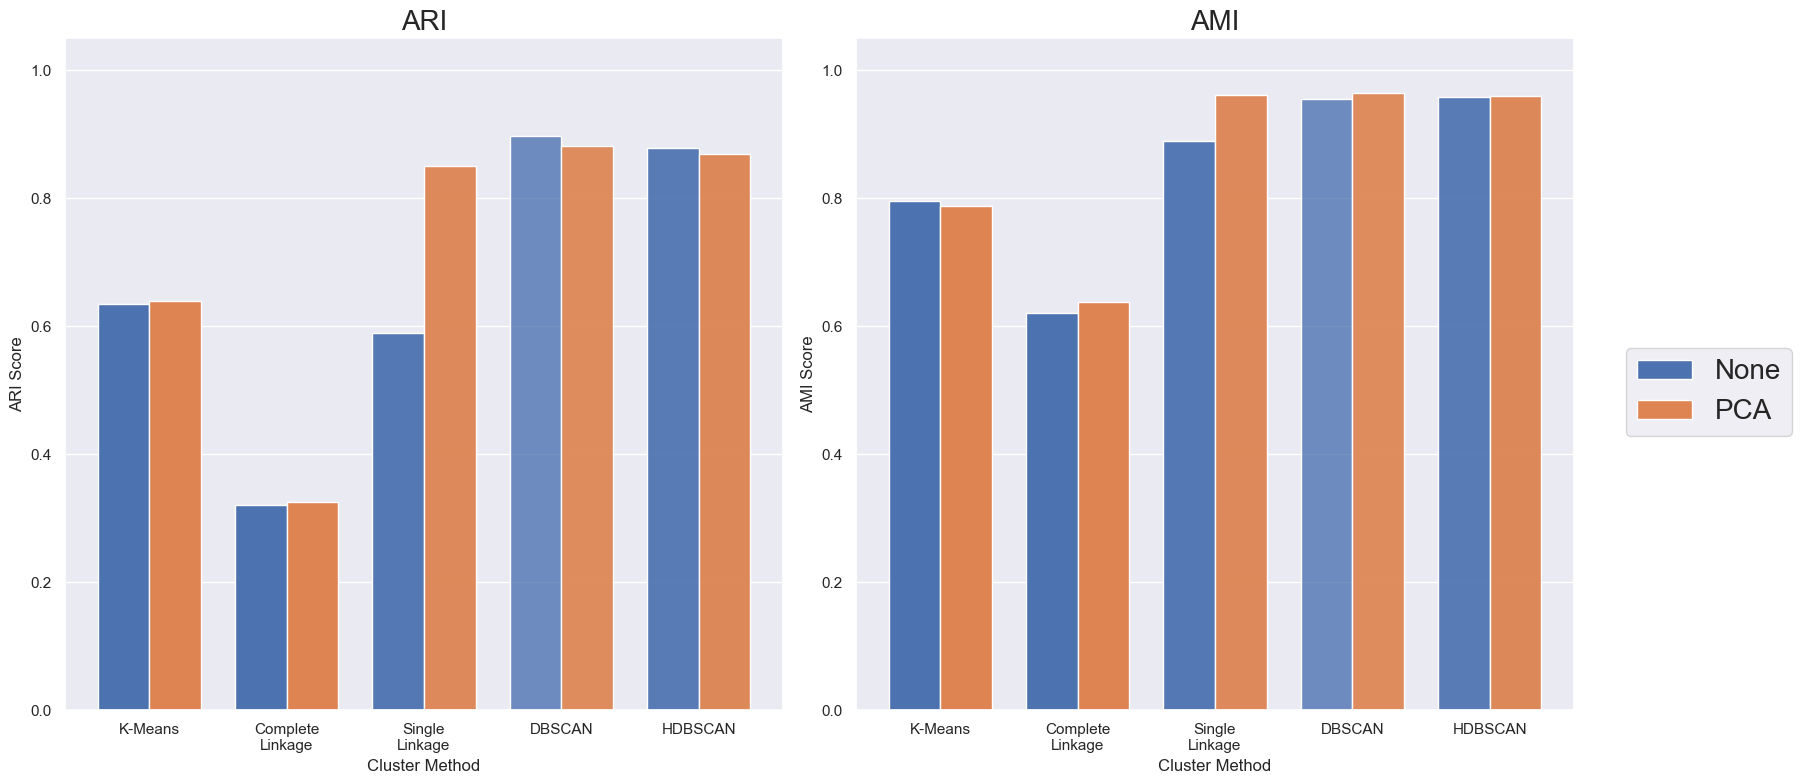

In [39]:
plot_scores(pd.concat([coil_raw_results_long, coil_pca_results_long]))

In [40]:
umap_coil = umap.UMAP(n_neighbors=5, n_components=4, min_dist=1e-8, random_state=0, n_epochs=1000).fit_transform(raw_coil)

In [41]:
%%time
km_umap_labels = cluster.KMeans(n_clusters=20).fit_predict(umap_coil)
cl_umap_labels = cluster.AgglomerativeClustering(n_clusters=20, linkage="complete").fit_predict(umap_coil)
sl_umap_labels = cluster.AgglomerativeClustering(n_clusters=80, linkage="single").fit_predict(umap_coil)
db_umap_labels = cluster.DBSCAN(eps=0.3).fit_predict(umap_coil)
hd_umap_labels = hdbscan.HDBSCAN(min_samples=3, min_cluster_size=20).fit_predict(umap_coil)

CPU times: user 694 ms, sys: 101 ms, total: 795 ms
Wall time: 286 ms


In [42]:
coil_umap_results = pd.DataFrame(
    [
        eval_clusters(km_umap_labels, coil_20_target, raw_coil, cluster_method="K-Means"),
        eval_clusters(cl_umap_labels, coil_20_target, raw_coil, cluster_method="Complete\nLinkage"),
        eval_clusters(sl_umap_labels, coil_20_target, raw_coil, cluster_method="Single\nLinkage"),
        eval_clusters(db_umap_labels, coil_20_target, raw_coil, cluster_method="DBSCAN"),
        eval_clusters(hd_umap_labels, coil_20_target, raw_coil, cluster_method="HDBSCAN"),
    ]
)
coil_umap_results_long = coil_umap_results.melt(["Method", "Pct Clustered"], var_name="Score Type", value_name="Score")
coil_umap_results_long["Dim Reduction"] = "UMAP"

ARI: 0.8396
AMI: 0.9343
Silhouette: 0.1241
ARI: 0.8119
AMI: 0.9380
Silhouette: 0.1153
ARI: 0.6904
AMI: 0.8509
Silhouette: 0.0707
Pct clustered: 95.35%
ARI: 0.7946
AMI: 0.9146
Silhouette: 0.0530
Pct clustered: 99.10%
ARI: 0.7963
AMI: 0.9460
Silhouette: 0.1072


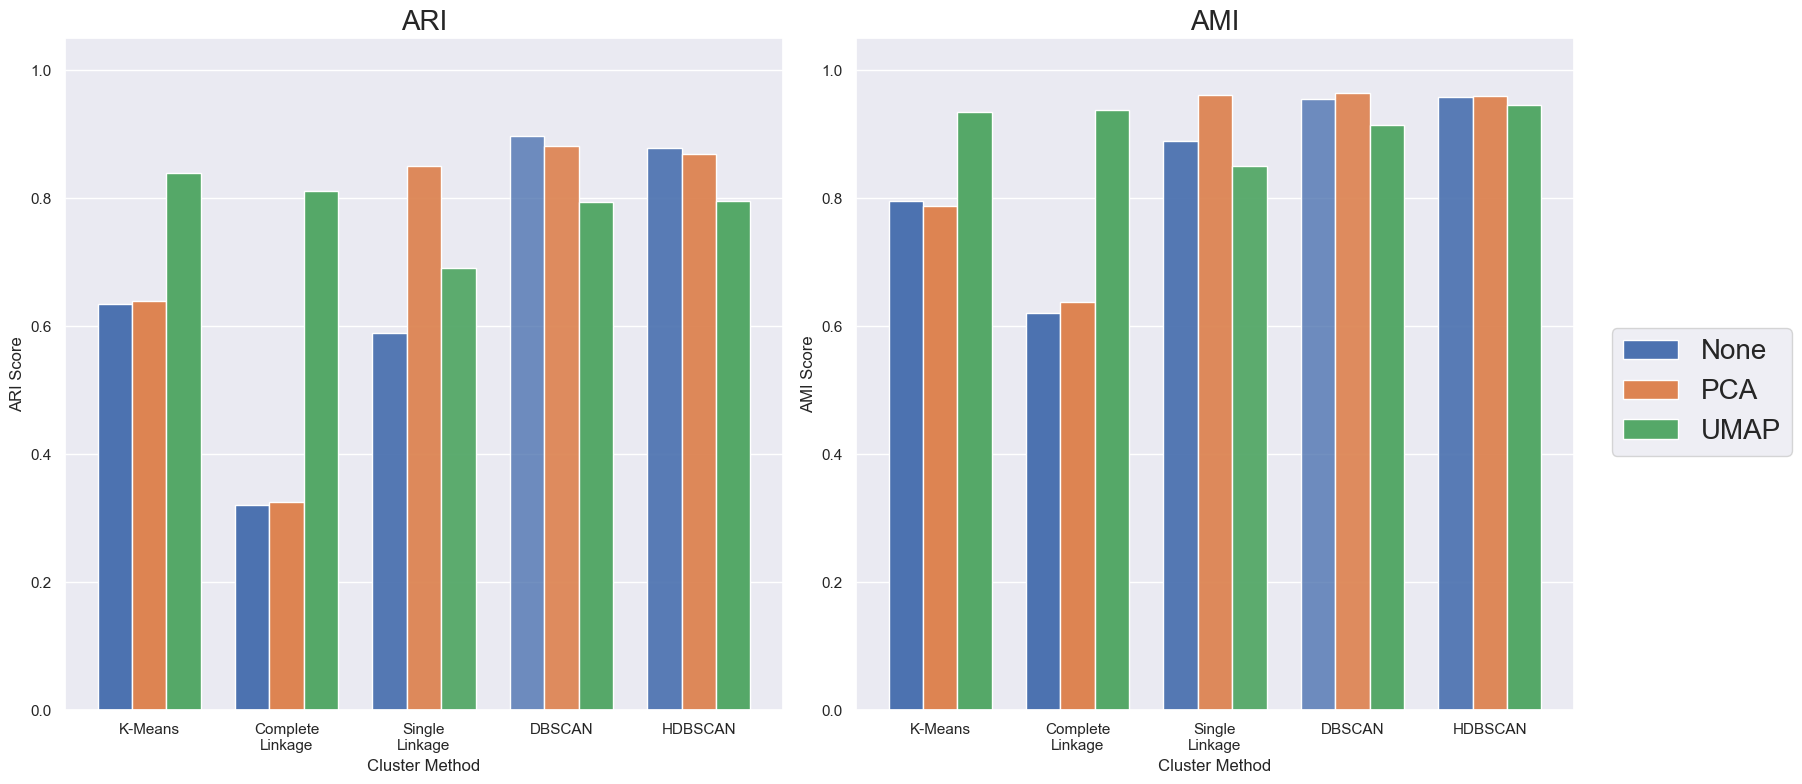

In [43]:
plot_scores(pd.concat([coil_raw_results_long, coil_pca_results_long, coil_umap_results_long]))

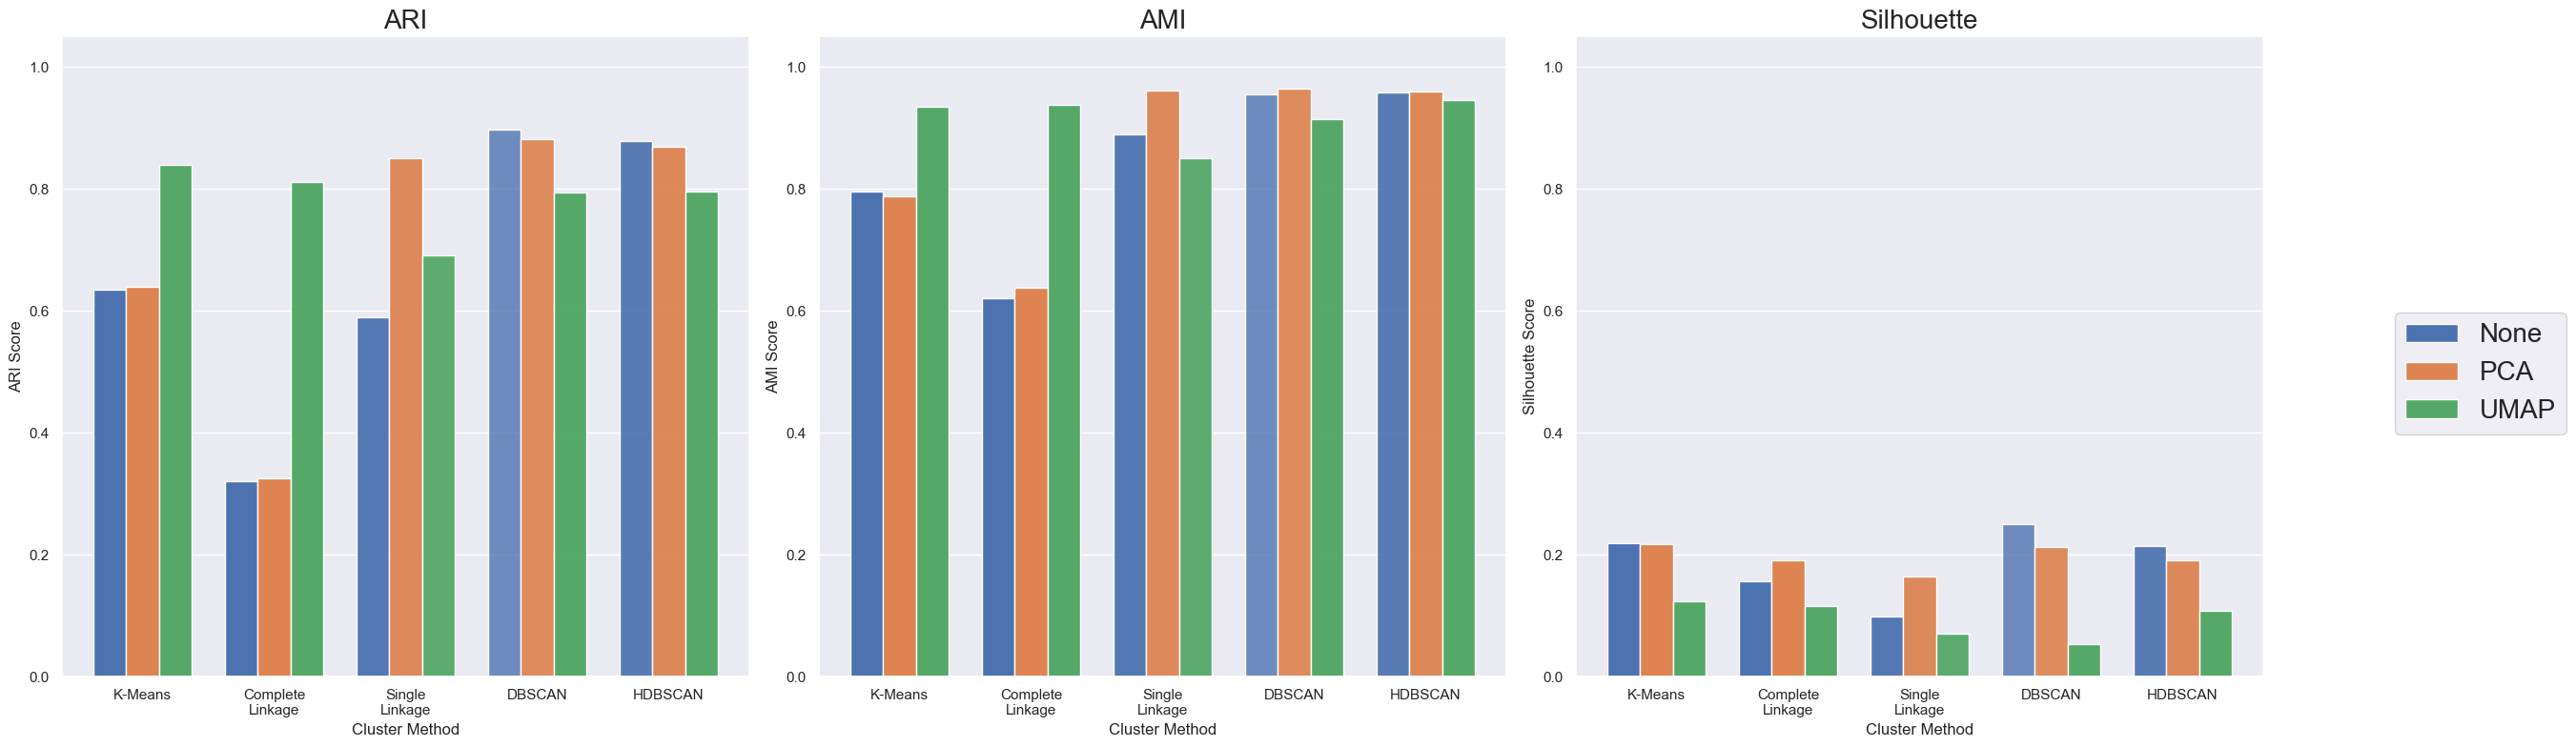

In [44]:
plot_scores(
    pd.concat([coil_raw_results_long, coil_pca_results_long, coil_umap_results_long]),
    score_types=("ARI", "AMI", "Silhouette")
)

# MNIST Clustering

In [45]:
raw_mnist = mnist.data.astype(np.float32)[:35000]

In [46]:
%%time
km_labels = cluster.KMeans(n_clusters=10).fit_predict(raw_mnist)
cl_labels = cluster.AgglomerativeClustering(n_clusters=10, linkage="complete").fit_predict(raw_mnist)
sl_labels = cluster.AgglomerativeClustering(n_clusters=80, linkage="single").fit_predict(raw_mnist)
db_labels = cluster.DBSCAN(eps=1000.0).fit_predict(raw_mnist)
hd_labels = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=100).fit_predict(raw_mnist)

CPU times: user 1h 38min 58s, sys: 4min, total: 1h 42min 59s
Wall time: 1h 45min


In [47]:
mnist_raw_results = pd.DataFrame(
    [
        eval_clusters(km_labels, mnist.target[:35000], raw_mnist, cluster_method="K-Means"),
        eval_clusters(cl_labels, mnist.target[:35000], raw_mnist, cluster_method="Complete\nLinkage"),
        eval_clusters(sl_labels, mnist.target[:35000], raw_mnist, cluster_method="Single\nLinkage"),
        eval_clusters(db_labels, mnist.target[:35000], raw_mnist, cluster_method="DBSCAN"),
        eval_clusters(hd_labels, mnist.target[:35000], raw_mnist, cluster_method="HDBSCAN"),
    ]
)
mnist_raw_results_long = mnist_raw_results.melt(["Method", "Pct Clustered"], var_name="Score Type", value_name="Score")
mnist_raw_results_long["Dim Reduction"] = "None"

ARI: 0.3563
AMI: 0.4777
Silhouette: 0.0558
ARI: 0.1013
AMI: 0.2630
Silhouette: 0.0151
ARI: 0.0000
AMI: 0.0000
Silhouette: 0.1518
Pct clustered: 99.77%
ARI: 0.1101
AMI: 0.2756
Silhouette: -0.1342
Pct clustered: 24.01%
ARI: 0.9988
AMI: 0.9973
Silhouette: 0.2125
Pct clustered: 14.67%


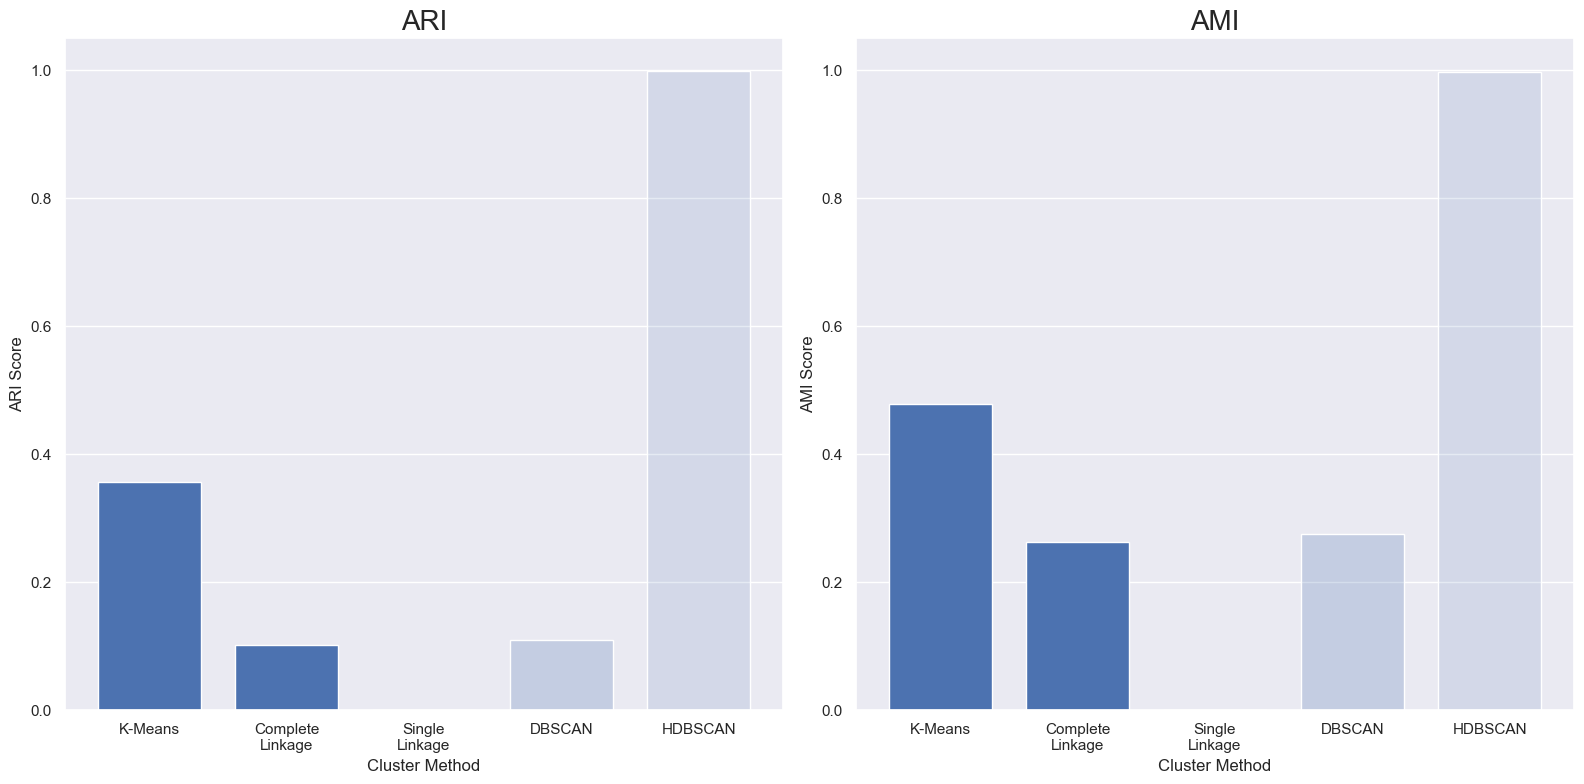

In [48]:
plot_scores(mnist_raw_results_long)

In [49]:
pca_mnist = PCA(n_components=32).fit_transform(raw_mnist)

In [50]:
%%time
km_pca_labels = cluster.KMeans(n_clusters=10).fit_predict(pca_mnist)
cl_pca_labels = cluster.AgglomerativeClustering(n_clusters=10, linkage="complete").fit_predict(pca_mnist)
sl_pca_labels = cluster.AgglomerativeClustering(n_clusters=80, linkage="single").fit_predict(pca_mnist)
db_pca_labels = cluster.DBSCAN(eps=600.0).fit_predict(pca_mnist)
hd_pca_labels = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=100).fit_predict(pca_mnist)

CPU times: user 8min 34s, sys: 1min 7s, total: 9min 41s
Wall time: 10min 42s


In [51]:
mnist_pca_results = pd.DataFrame(
    [
        eval_clusters(km_pca_labels, mnist.target[:35000], raw_mnist, cluster_method="K-Means"),
        eval_clusters(cl_pca_labels, mnist.target[:35000], raw_mnist, cluster_method="Complete\nLinkage"),
        eval_clusters(sl_pca_labels, mnist.target[:35000], raw_mnist, cluster_method="Single\nLinkage"),
        eval_clusters(db_pca_labels, mnist.target[:35000], raw_mnist, cluster_method="DBSCAN"),
        eval_clusters(hd_pca_labels, mnist.target[:35000], raw_mnist, cluster_method="HDBSCAN"),
    ]
)
mnist_pca_results_long = mnist_pca_results.melt(["Method", "Pct Clustered"], var_name="Score Type", value_name="Score")
mnist_pca_results_long["Dim Reduction"] = "PCA"

ARI: 0.3536
AMI: 0.4742
Silhouette: 0.0560
ARI: 0.1974
AMI: 0.3782
Silhouette: 0.0340
ARI: 0.0000
AMI: 0.0000
Silhouette: 0.1333
Pct clustered: 99.78%
ARI: 0.1004
AMI: 0.2901
Silhouette: -0.1541
Pct clustered: 26.10%
ARI: 0.9940
AMI: 0.9889
Silhouette: 0.2155
Pct clustered: 14.65%


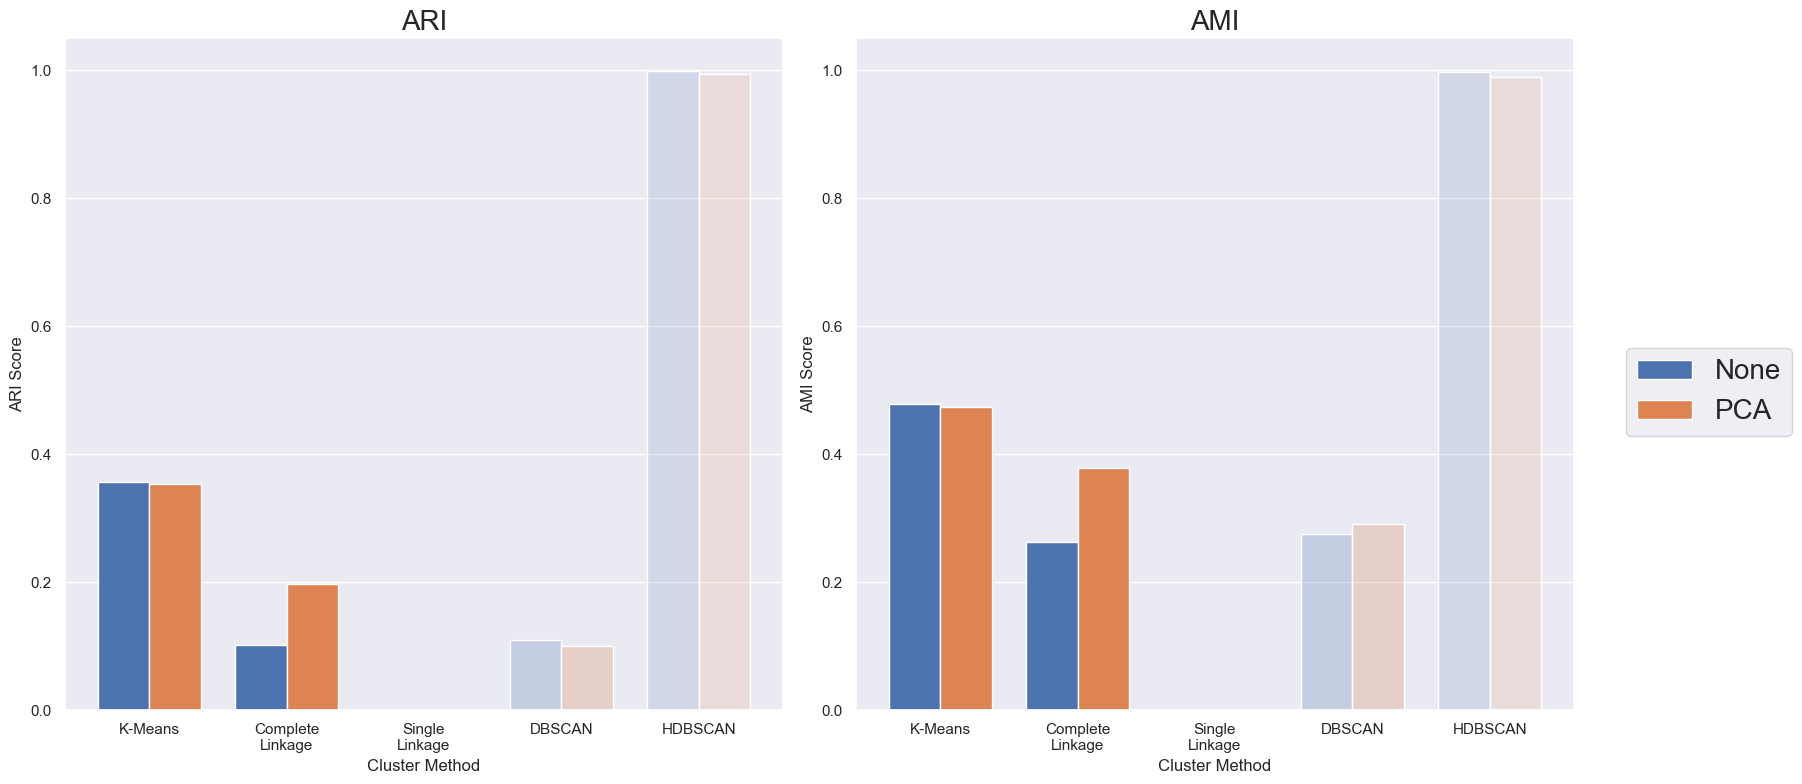

In [52]:
plot_scores(pd.concat([mnist_raw_results_long, mnist_pca_results_long]))

In [53]:
umap_mnist = umap.UMAP(n_neighbors=10, n_components=4, min_dist=1e-8, random_state=42, n_epochs=500).fit_transform(raw_mnist)

In [54]:
%%time
km_umap_labels = cluster.KMeans(n_clusters=10).fit_predict(umap_mnist)
cl_umap_labels = cluster.AgglomerativeClustering(n_clusters=10, linkage="complete").fit_predict(umap_mnist)
sl_umap_labels = cluster.AgglomerativeClustering(n_clusters=80, linkage="single").fit_predict(umap_mnist)
db_umap_labels = cluster.DBSCAN(eps=0.1).fit_predict(umap_mnist)
hd_umap_labels = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=100).fit_predict(umap_mnist)

CPU times: user 4min 8s, sys: 40.3 s, total: 4min 48s
Wall time: 5min 25s


In [55]:
mnist_umap_results = pd.DataFrame(
    [
        eval_clusters(km_umap_labels, mnist.target[:35000], raw_mnist, cluster_method="K-Means"),
        eval_clusters(cl_umap_labels, mnist.target[:35000], raw_mnist, cluster_method="Complete\nLinkage"),
        eval_clusters(sl_umap_labels, mnist.target[:35000], raw_mnist, cluster_method="Single\nLinkage"),
        eval_clusters(db_umap_labels, mnist.target[:35000], raw_mnist, cluster_method="DBSCAN"),
        eval_clusters(hd_umap_labels, mnist.target[:35000], raw_mnist, cluster_method="HDBSCAN"),
    ]
)
mnist_umap_results_long = mnist_umap_results.melt(["Method", "Pct Clustered"], var_name="Score Type", value_name="Score")
mnist_umap_results_long["Dim Reduction"] = "UMAP"

ARI: 0.7669
AMI: 0.8374
Silhouette: 0.0333
ARI: 0.7690
AMI: 0.8398
Silhouette: 0.0333
ARI: 0.7604
AMI: 0.8518
Silhouette: -0.0415
Pct clustered: 99.69%
ARI: 0.7931
AMI: 0.8105
Silhouette: -0.1945
Pct clustered: 92.65%
ARI: 0.8285
AMI: 0.8782
Silhouette: 0.0482
Pct clustered: 99.49%


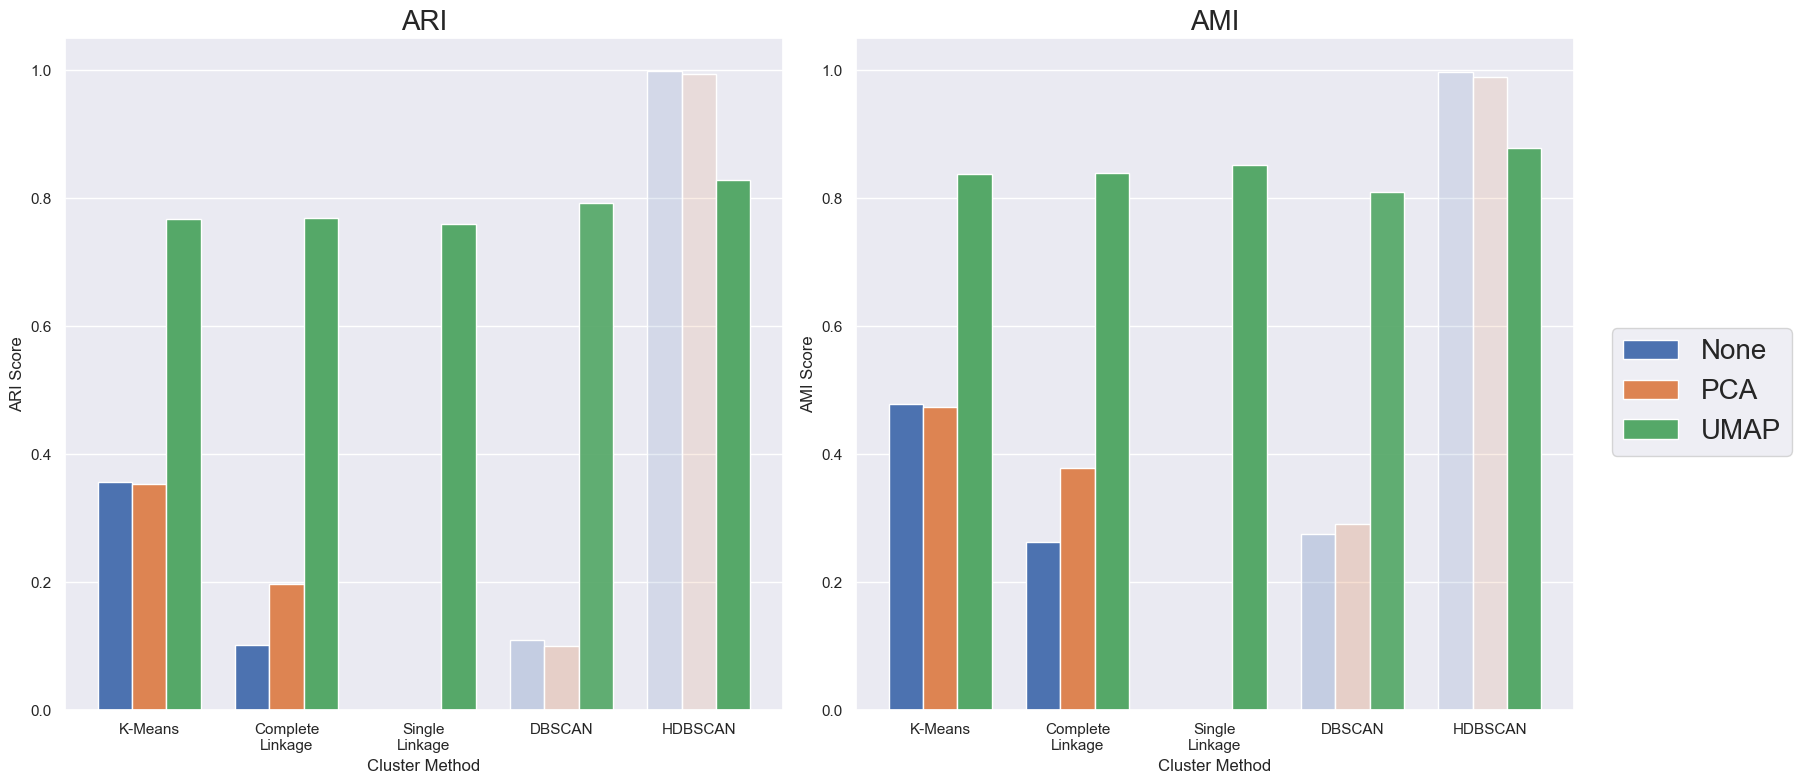

In [56]:
plot_scores(pd.concat([mnist_raw_results_long, mnist_pca_results_long, mnist_umap_results_long]))

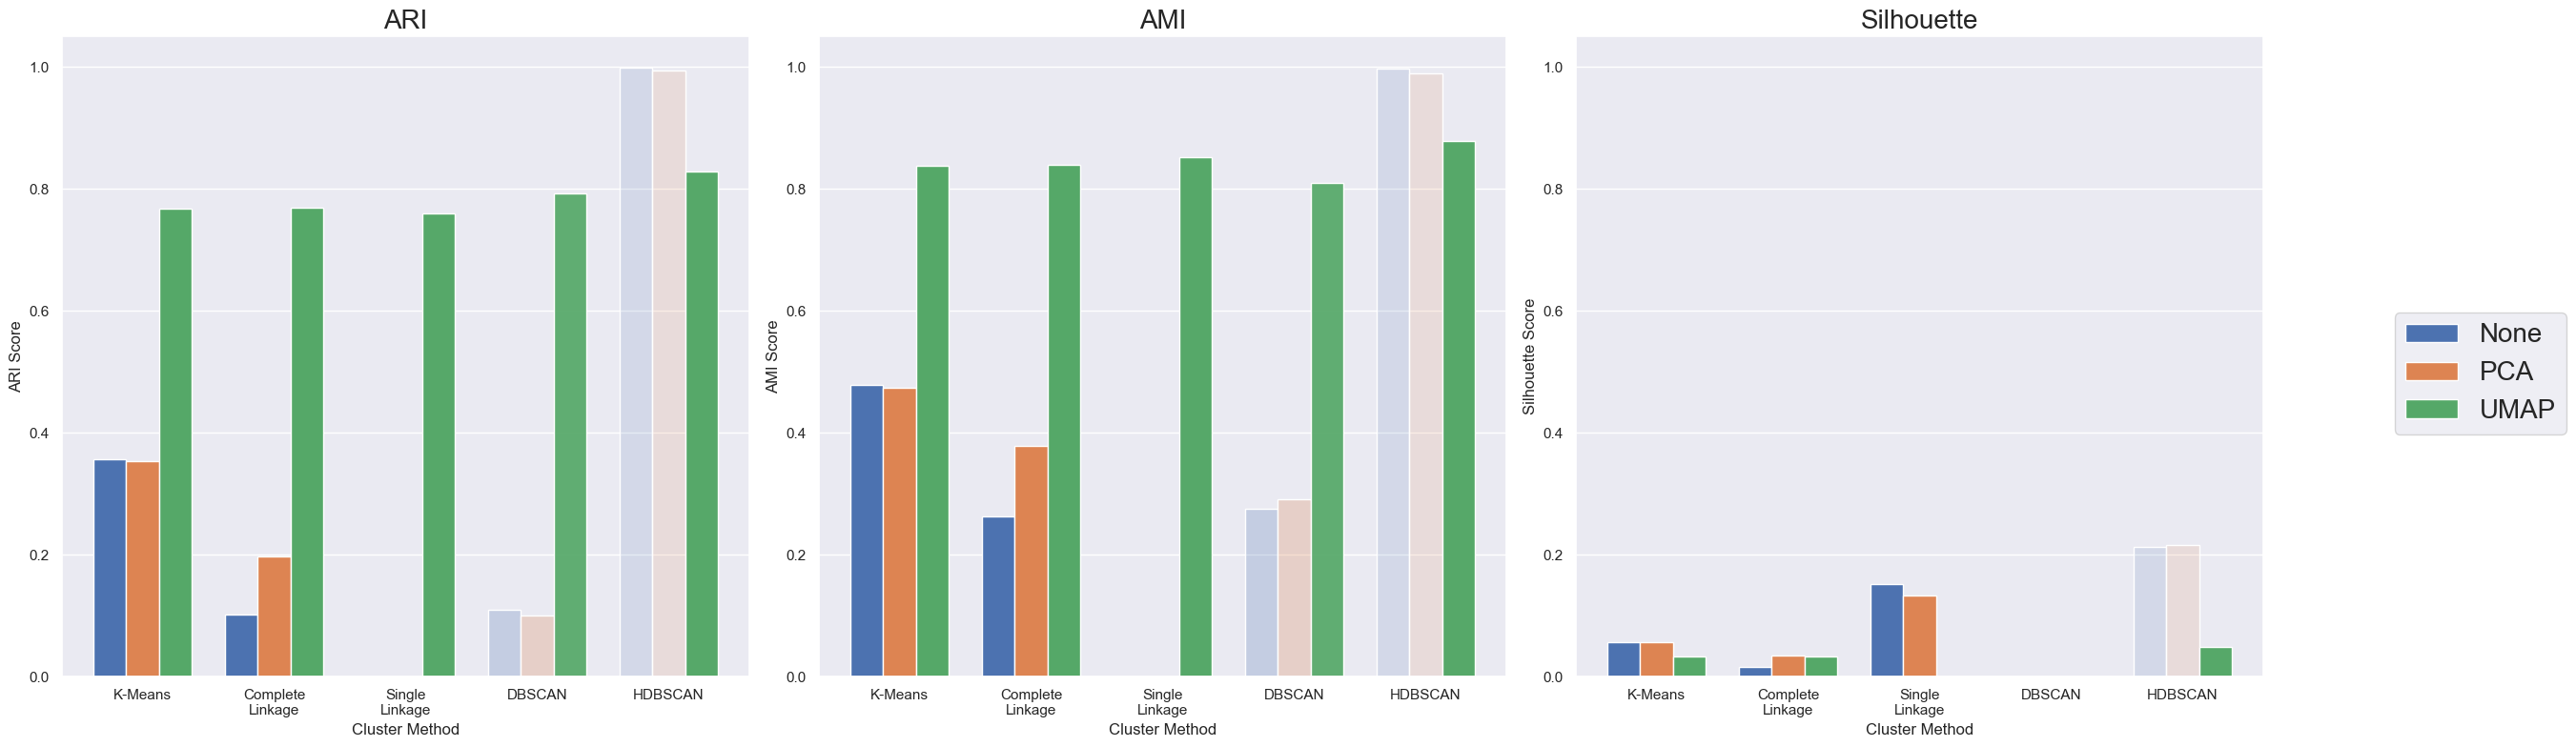

In [57]:
plot_scores(
    pd.concat([mnist_raw_results_long, mnist_pca_results_long, mnist_umap_results_long]),
    score_types=("ARI", "AMI", "Silhouette")
)

# USPS Clustering

In [58]:
raw_usps = usps.data.astype(np.float32)

In [59]:
%%time
km_labels = cluster.KMeans(n_clusters=10).fit_predict(raw_usps)
cl_labels = cluster.AgglomerativeClustering(n_clusters=10, linkage="complete").fit_predict(raw_usps)
sl_labels = cluster.AgglomerativeClustering(n_clusters=80, linkage="single").fit_predict(raw_usps)
db_labels = cluster.DBSCAN(eps=3.5).fit_predict(raw_usps)
hd_labels = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=100).fit_predict(raw_usps)

CPU times: user 3min 17s, sys: 11 s, total: 3min 28s
Wall time: 3min 23s


In [60]:
usps_raw_results = pd.DataFrame(
    [
        eval_clusters(km_labels, usps.target, raw_usps, cluster_method="K-Means"),
        eval_clusters(cl_labels, usps.target, raw_usps, cluster_method="Complete\nLinkage"),
        eval_clusters(sl_labels, usps.target, raw_usps, cluster_method="Single\nLinkage"),
        eval_clusters(db_labels, usps.target, raw_usps, cluster_method="DBSCAN"),
        eval_clusters(hd_labels, usps.target, raw_usps, cluster_method="HDBSCAN"),
    ]
)
usps_raw_results_long = usps_raw_results.melt(["Method", "Pct Clustered"], var_name="Score Type", value_name="Score")
usps_raw_results_long["Dim Reduction"] = "None"

ARI: 0.5377
AMI: 0.6140
Silhouette: 0.1584
ARI: 0.1881
AMI: 0.3712
Silhouette: 0.0414
ARI: 0.0000
AMI: 0.0000
Silhouette: 0.1075
Pct clustered: 99.13%
ARI: 0.1936
AMI: 0.4639
Silhouette: -0.1174
Pct clustered: 47.35%
ARI: 0.9432
AMI: 0.9313
Silhouette: 0.4299
Pct clustered: 27.40%


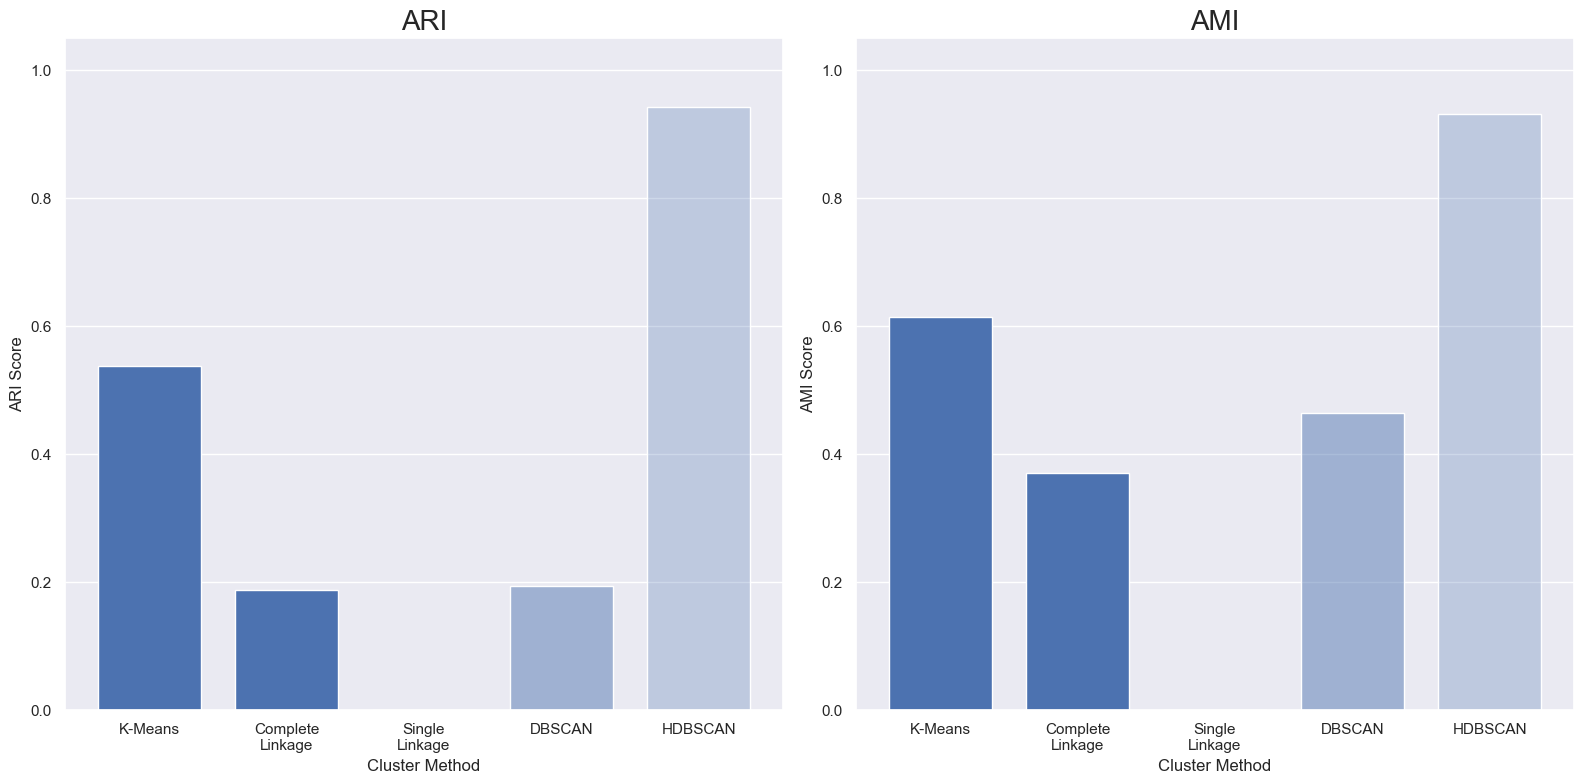

In [61]:
plot_scores(usps_raw_results_long)

In [62]:
pca_usps = PCA(n_components=32).fit_transform(raw_usps)

In [63]:
%%time
km_pca_labels = cluster.KMeans(n_clusters=10).fit_predict(pca_usps)
cl_pca_labels = cluster.AgglomerativeClustering(n_clusters=10, linkage="complete").fit_predict(pca_usps)
sl_pca_labels = cluster.AgglomerativeClustering(n_clusters=80, linkage="single").fit_predict(pca_usps)
db_pca_labels = cluster.DBSCAN(eps=2.0).fit_predict(pca_usps)
hd_pca_labels = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=100).fit_predict(pca_usps)

CPU times: user 32.5 s, sys: 3.31 s, total: 35.8 s
Wall time: 31.8 s


In [64]:
usps_pca_results = pd.DataFrame(
    [
        eval_clusters(km_pca_labels, usps.target, raw_usps, cluster_method="K-Means"),
        eval_clusters(cl_pca_labels, usps.target, raw_usps, cluster_method="Complete\nLinkage"),
        eval_clusters(sl_pca_labels, usps.target, raw_usps, cluster_method="Single\nLinkage"),
        eval_clusters(db_pca_labels, usps.target, raw_usps, cluster_method="DBSCAN"),
        eval_clusters(hd_pca_labels, usps.target, raw_usps, cluster_method="HDBSCAN"),
    ]
)
usps_pca_results_long = usps_pca_results.melt(["Method", "Pct Clustered"], var_name="Score Type", value_name="Score")
usps_pca_results_long["Dim Reduction"] = "PCA"

ARI: 0.5370
AMI: 0.6129
Silhouette: 0.1583
ARI: 0.2455
AMI: 0.4033
Silhouette: 0.0731
ARI: 0.0000
AMI: 0.0000
Silhouette: 0.1896
Pct clustered: 99.12%
ARI: 0.9754
AMI: 0.8675
Silhouette: 0.3813
Pct clustered: 18.28%
ARI: 0.9586
AMI: 0.9378
Silhouette: 0.3954
Pct clustered: 29.47%


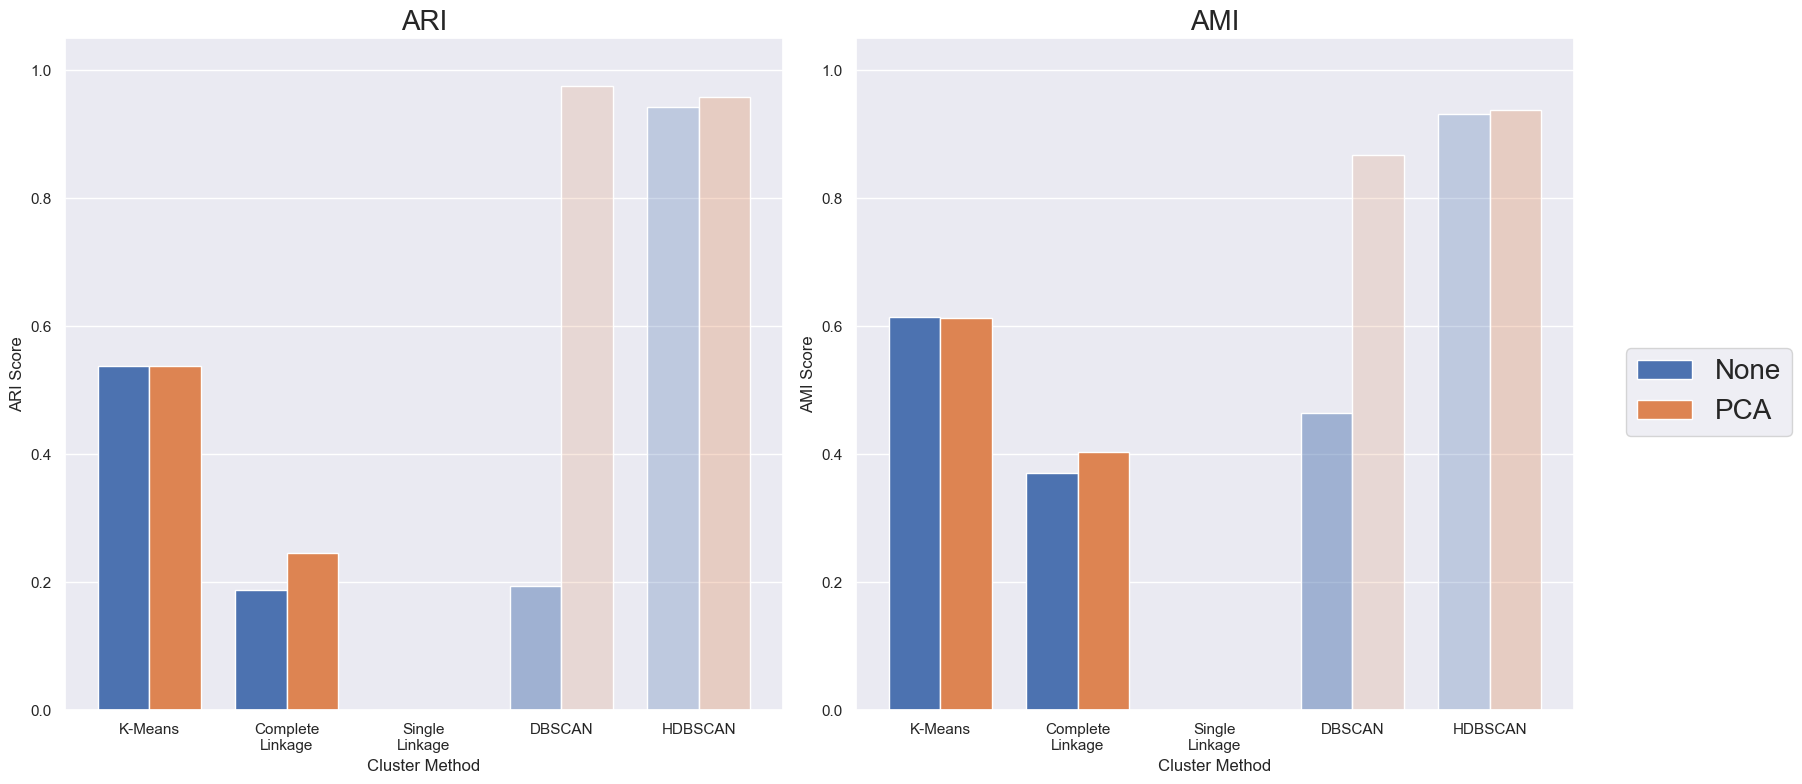

In [65]:
plot_scores(pd.concat([usps_raw_results_long, usps_pca_results_long]))

In [66]:
umap_usps = umap.UMAP(n_neighbors=10, n_components=4, min_dist=1e-8, random_state=42, n_epochs=500).fit_transform(raw_usps)

In [67]:
%%time
km_umap_labels = cluster.KMeans(n_clusters=10).fit_predict(umap_usps)
cl_umap_labels = cluster.AgglomerativeClustering(n_clusters=10, linkage="complete").fit_predict(umap_usps)
sl_umap_labels = cluster.AgglomerativeClustering(n_clusters=80, linkage="single").fit_predict(umap_usps)
db_umap_labels = cluster.DBSCAN(eps=0.15).fit_predict(umap_usps)
hd_umap_labels = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=100).fit_predict(umap_usps)

CPU times: user 11 s, sys: 1.31 s, total: 12.3 s
Wall time: 11.6 s


In [68]:
usps_umap_results = pd.DataFrame(
    [
        eval_clusters(km_umap_labels, usps.target, raw_usps, cluster_method="K-Means"),
        eval_clusters(cl_umap_labels, usps.target, raw_usps, cluster_method="Complete\nLinkage"),
        eval_clusters(sl_umap_labels, usps.target, raw_usps, cluster_method="Single\nLinkage"),
        eval_clusters(db_umap_labels, usps.target, raw_usps, cluster_method="DBSCAN"),
        eval_clusters(hd_umap_labels, usps.target, raw_usps, cluster_method="HDBSCAN"),
    ]
)
usps_umap_results_long = usps_umap_results.melt(["Method", "Pct Clustered"], var_name="Score Type", value_name="Score")
usps_umap_results_long["Dim Reduction"] = "UMAP"

ARI: 0.8056
AMI: 0.8759
Silhouette: 0.1450
ARI: 0.6918
AMI: 0.8377
Silhouette: 0.1018
ARI: 0.8812
AMI: 0.8989
Silhouette: 0.0541
Pct clustered: 98.92%
ARI: 0.8469
AMI: 0.8546
Silhouette: -0.0917
Pct clustered: 97.21%
ARI: 0.8811
AMI: 0.8989
Silhouette: 0.1395
Pct clustered: 99.97%


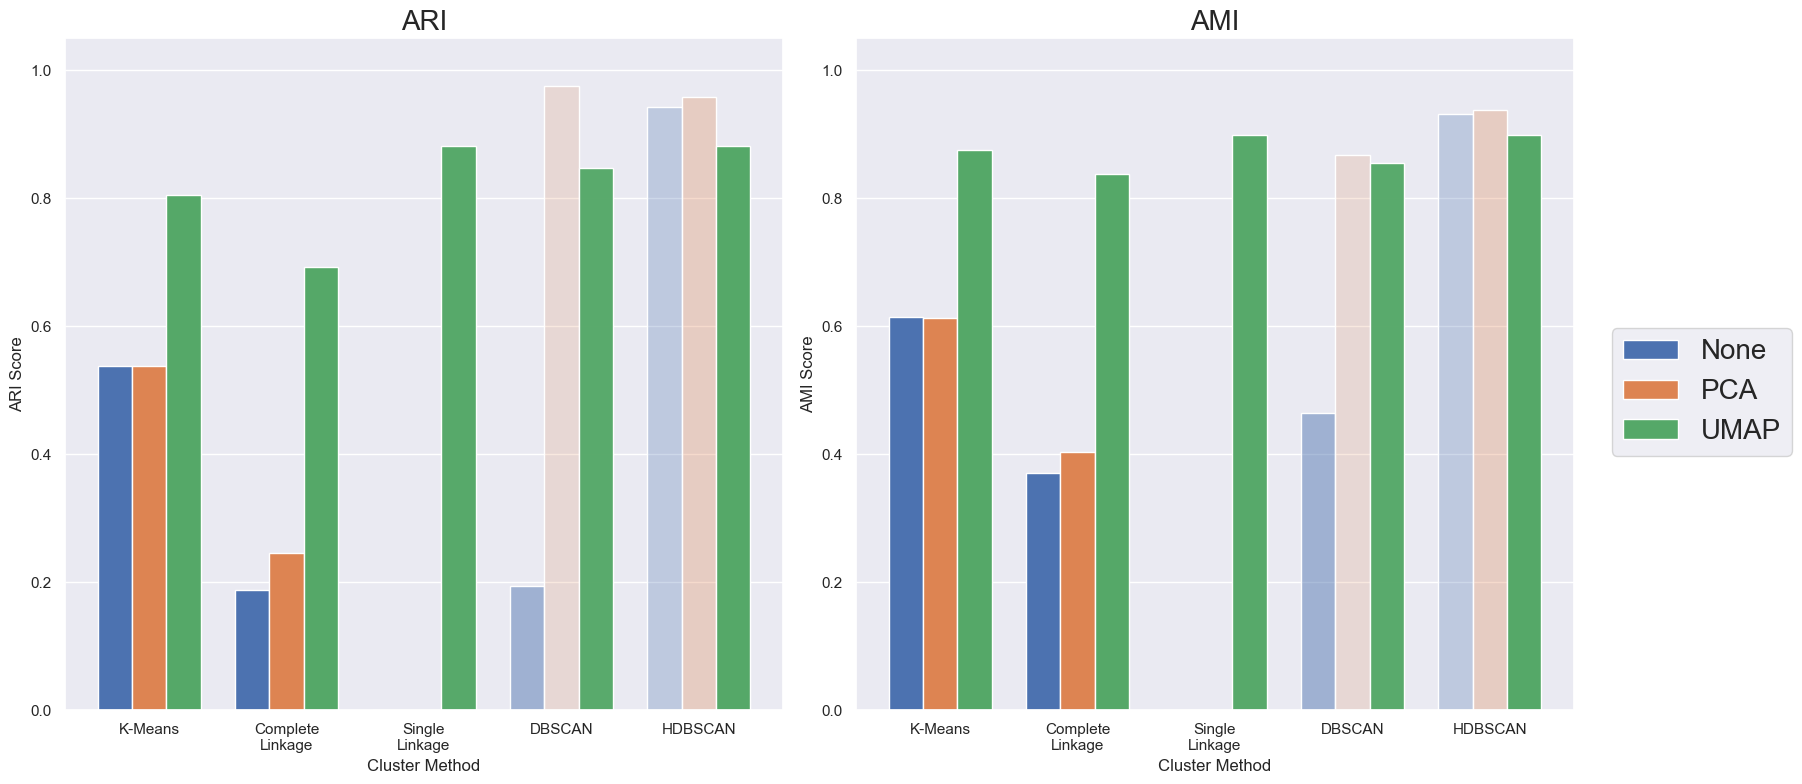

In [69]:
plot_scores(pd.concat([usps_raw_results_long, usps_pca_results_long, usps_umap_results_long]))

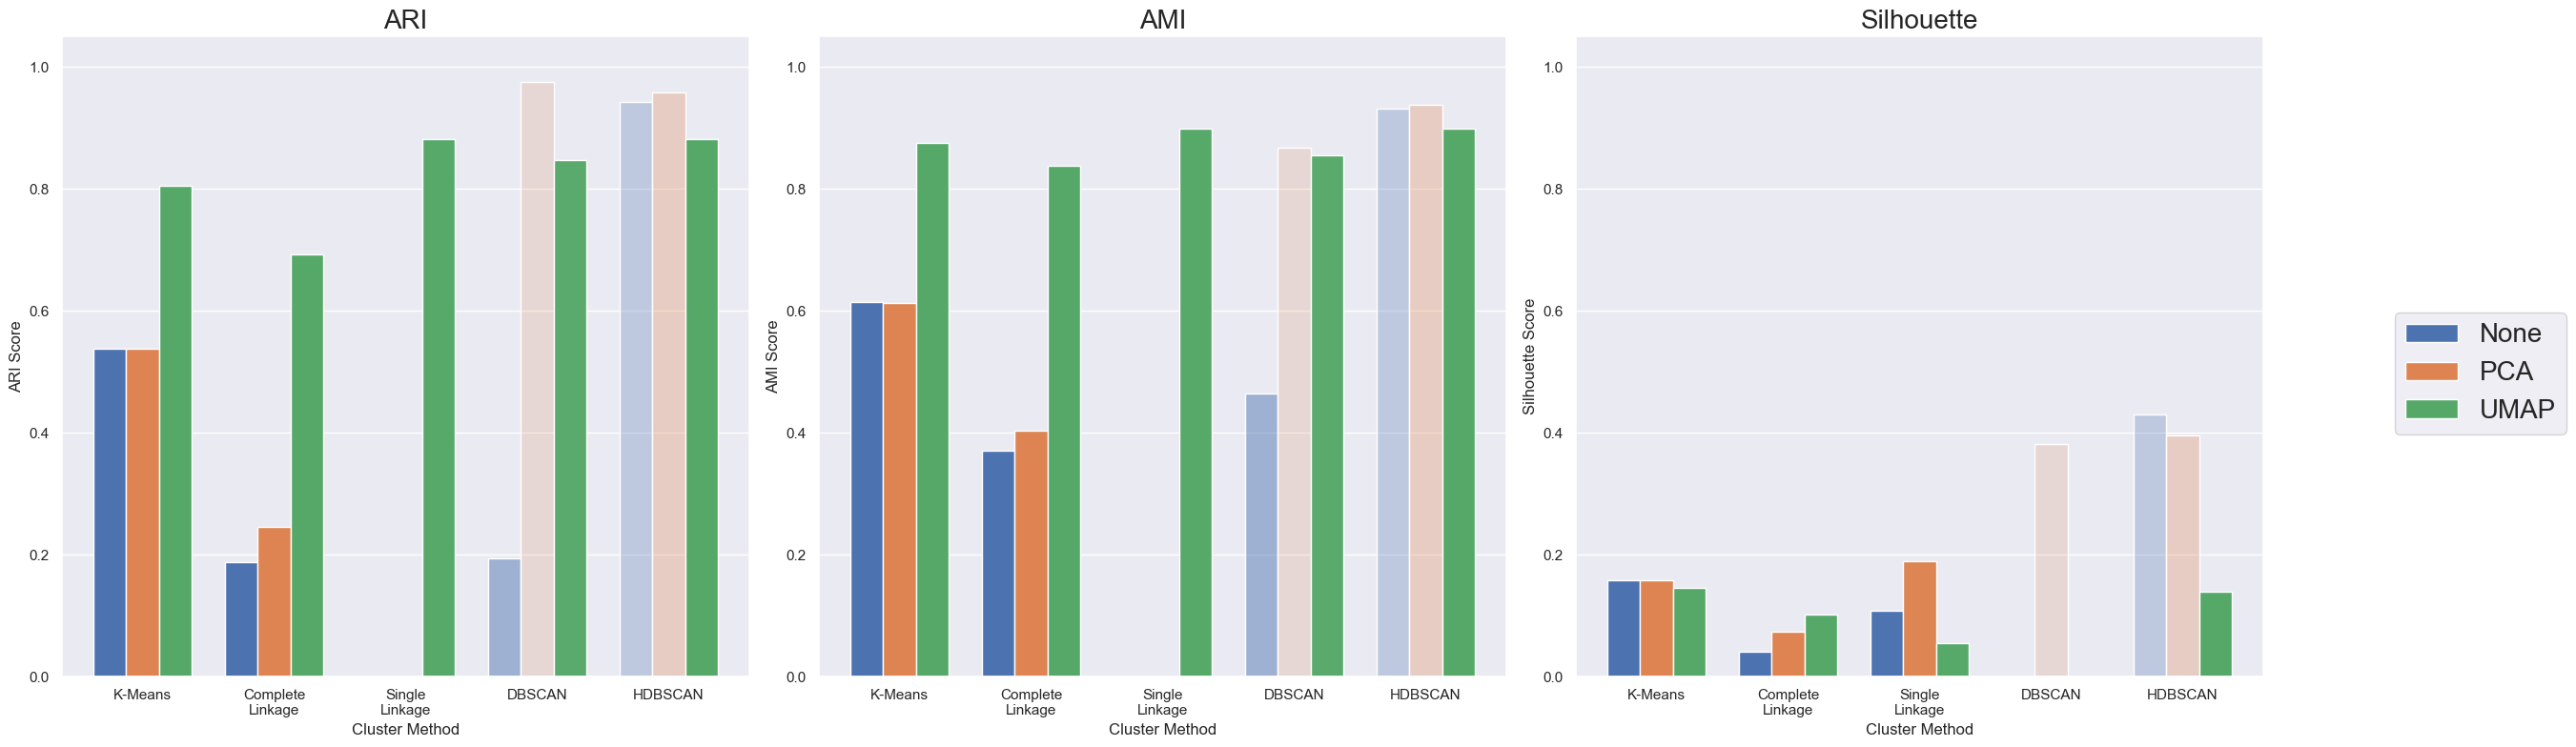

In [70]:
plot_scores(
    pd.concat([usps_raw_results_long, usps_pca_results_long, usps_umap_results_long]),
    score_types=("ARI", "AMI", "Silhouette")
)

# Buildings Clustering

In [71]:
raw_buildings = buildings_data.astype(np.float32)

In [72]:
%%time
km_labels = cluster.KMeans(n_clusters=40).fit_predict(raw_buildings)
cl_labels = cluster.AgglomerativeClustering(n_clusters=40, linkage="complete").fit_predict(raw_buildings)
sl_labels = cluster.AgglomerativeClustering(n_clusters=120, linkage="single").fit_predict(raw_buildings)
db_labels = cluster.DBSCAN(eps=6000).fit_predict(raw_buildings)
hd_labels = hdbscan.HDBSCAN(min_samples=3, min_cluster_size=20).fit_predict(raw_buildings)

CPU times: user 35min 12s, sys: 1min 1s, total: 36min 14s
Wall time: 35min 24s


In [73]:
buildings_raw_results = pd.DataFrame(
    [
        eval_clusters(km_labels, buildings_target, raw_buildings, cluster_method="K-Means"),
        eval_clusters(cl_labels, buildings_target, raw_buildings, cluster_method="Complete\nLinkage"),
        eval_clusters(sl_labels, buildings_target, raw_buildings, cluster_method="Single\nLinkage"),
        eval_clusters(db_labels, buildings_target, raw_buildings, cluster_method="DBSCAN"),
        eval_clusters(hd_labels, buildings_target, raw_buildings, cluster_method="HDBSCAN"),
    ]
)
buildings_raw_results_long = buildings_raw_results.melt(["Method", "Pct Clustered"], var_name="Score Type", value_name="Score")
buildings_raw_results_long["Dim Reduction"] = "None"

ARI: 0.2013
AMI: 0.5000
Silhouette: 0.0709
ARI: 0.1322
AMI: 0.4259
Silhouette: 0.0427
ARI: 0.0036
AMI: 0.0861
Silhouette: -0.0796
Pct clustered: 96.86%
ARI: 0.4300
AMI: 0.7809
Silhouette: 0.2043
Pct clustered: 44.16%
ARI: 0.6616
AMI: 0.8702
Silhouette: 0.0929
Pct clustered: 59.74%


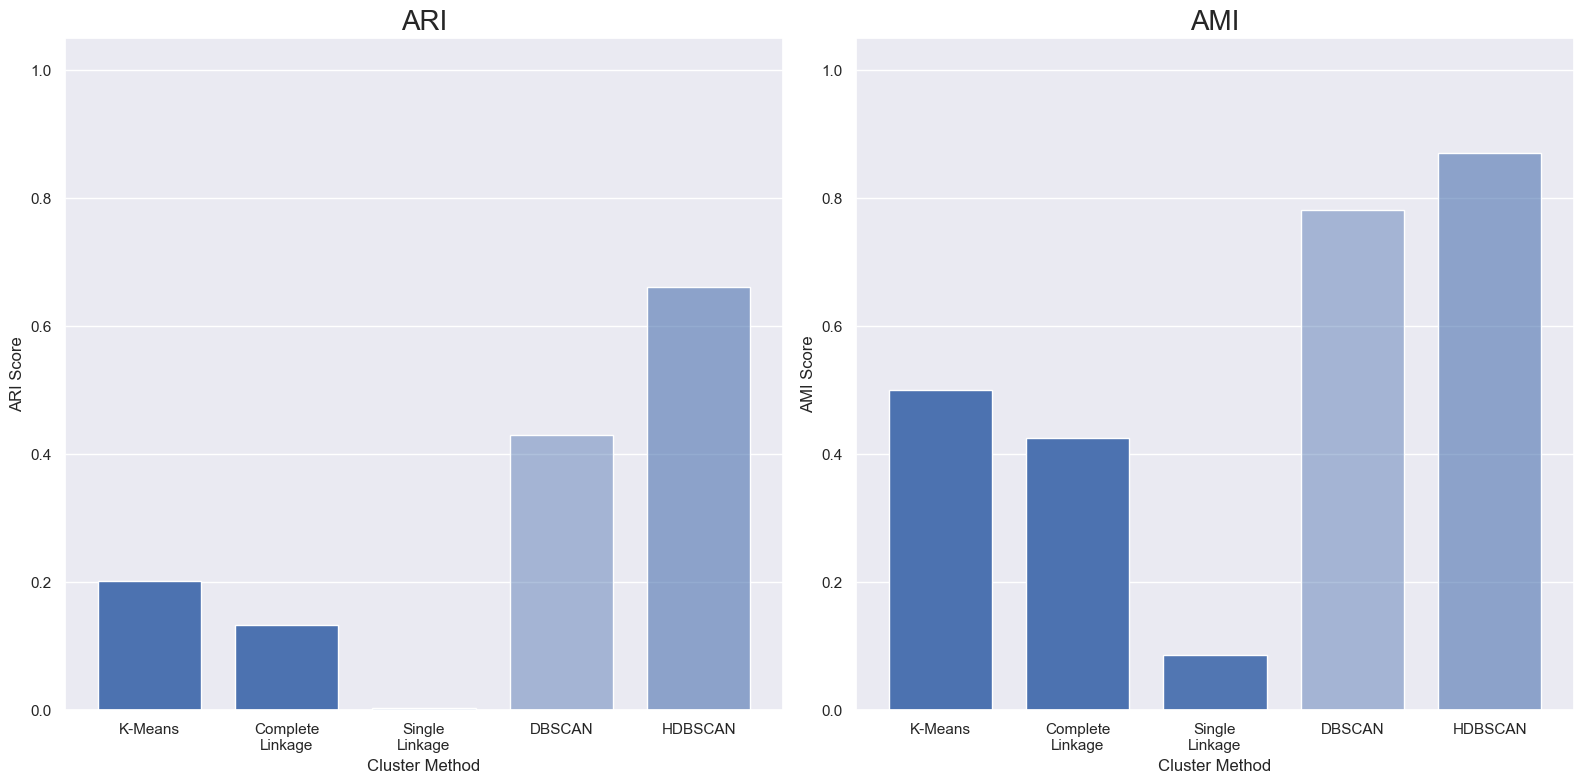

In [74]:
plot_scores(buildings_raw_results_long)

In [75]:
pca_buildings = PCA(n_components=32).fit_transform(raw_buildings)

In [76]:
%%time
km_pca_labels = cluster.KMeans(n_clusters=40).fit_predict(pca_buildings)
cl_pca_labels = cluster.AgglomerativeClustering(n_clusters=40, linkage="complete").fit_predict(pca_buildings)
sl_pca_labels = cluster.AgglomerativeClustering(n_clusters=120, linkage="single").fit_predict(pca_buildings)
db_pca_labels = cluster.DBSCAN(eps=2000.0).fit_predict(pca_buildings)
hd_pca_labels = hdbscan.HDBSCAN(min_samples=3, min_cluster_size=20).fit_predict(pca_buildings)

CPU times: user 13.8 s, sys: 2.03 s, total: 15.9 s
Wall time: 12.3 s


In [77]:
buildings_pca_results = pd.DataFrame(
    [
        eval_clusters(km_pca_labels, buildings_target, raw_buildings, cluster_method="K-Means"),
        eval_clusters(cl_pca_labels, buildings_target, raw_buildings, cluster_method="Complete\nLinkage"),
        eval_clusters(sl_pca_labels, buildings_target, raw_buildings, cluster_method="Single\nLinkage"),
        eval_clusters(db_pca_labels, buildings_target, raw_buildings, cluster_method="DBSCAN"),
        eval_clusters(hd_pca_labels, buildings_target, raw_buildings, cluster_method="HDBSCAN"),
    ]
)
buildings_pca_results_long = buildings_pca_results.melt(["Method", "Pct Clustered"], var_name="Score Type", value_name="Score")
buildings_pca_results_long["Dim Reduction"] = "PCA"

ARI: 0.1863
AMI: 0.4832
Silhouette: 0.0723
ARI: 0.1349
AMI: 0.4333
Silhouette: 0.0405
ARI: 0.0133
AMI: 0.2431
Silhouette: -0.0929
Pct clustered: 96.89%
ARI: 0.3981
AMI: 0.7871
Silhouette: 0.1582
Pct clustered: 56.37%
ARI: 0.5551
AMI: 0.8284
Silhouette: 0.0592
Pct clustered: 71.90%


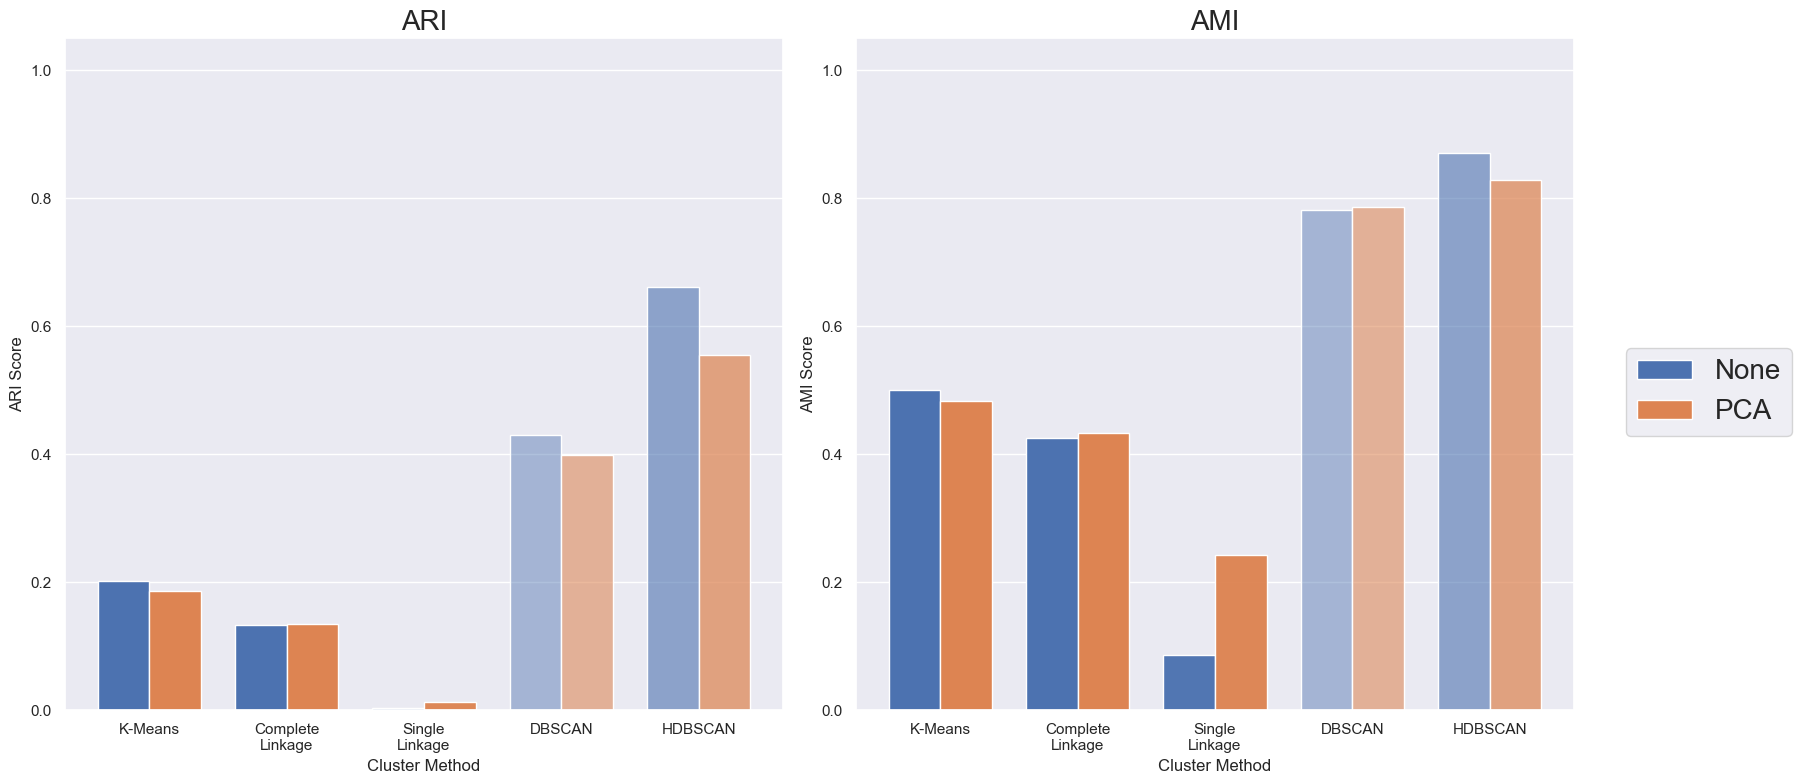

In [78]:
plot_scores(pd.concat([buildings_raw_results_long, buildings_pca_results_long]))

In [79]:
umap_buildings = umap.UMAP(n_neighbors=8, n_components=4, min_dist=1e-8, random_state=42, n_epochs=1000).fit_transform(raw_buildings)

In [80]:
%%time
km_umap_labels = cluster.KMeans(n_clusters=40).fit_predict(umap_buildings)
cl_umap_labels = cluster.AgglomerativeClustering(n_clusters=40, linkage="complete").fit_predict(umap_buildings)
sl_umap_labels = cluster.AgglomerativeClustering(n_clusters=120, linkage="single").fit_predict(umap_buildings)
db_umap_labels = cluster.DBSCAN(eps=0.25).fit_predict(umap_buildings)
hd_umap_labels = hdbscan.HDBSCAN(min_samples=3, min_cluster_size=20).fit_predict(umap_buildings)

CPU times: user 4.74 s, sys: 760 ms, total: 5.5 s
Wall time: 3.75 s


In [81]:
buildings_umap_results = pd.DataFrame(
    [
        eval_clusters(km_umap_labels, buildings_target, raw_buildings, cluster_method="K-Means"),
        eval_clusters(cl_umap_labels, buildings_target, raw_buildings, cluster_method="Complete\nLinkage"),
        eval_clusters(sl_umap_labels, buildings_target, raw_buildings, cluster_method="Single\nLinkage"),
        eval_clusters(db_umap_labels, buildings_target, raw_buildings, cluster_method="DBSCAN"),
        eval_clusters(hd_umap_labels, buildings_target, raw_buildings, cluster_method="HDBSCAN"),
    ]
)
buildings_umap_results_long = buildings_umap_results.melt(["Method", "Pct Clustered"], var_name="Score Type", value_name="Score")
buildings_umap_results_long["Dim Reduction"] = "UMAP"

ARI: 0.2551
AMI: 0.5851
Silhouette: 0.0001
ARI: 0.2646
AMI: 0.5754
Silhouette: -0.0110
ARI: 0.3393
AMI: 0.6608
Silhouette: 0.0289
Pct clustered: 99.21%
ARI: 0.3411
AMI: 0.6620
Silhouette: 0.0332
Pct clustered: 99.11%
ARI: 0.3993
AMI: 0.6834
Silhouette: 0.0365
Pct clustered: 91.24%


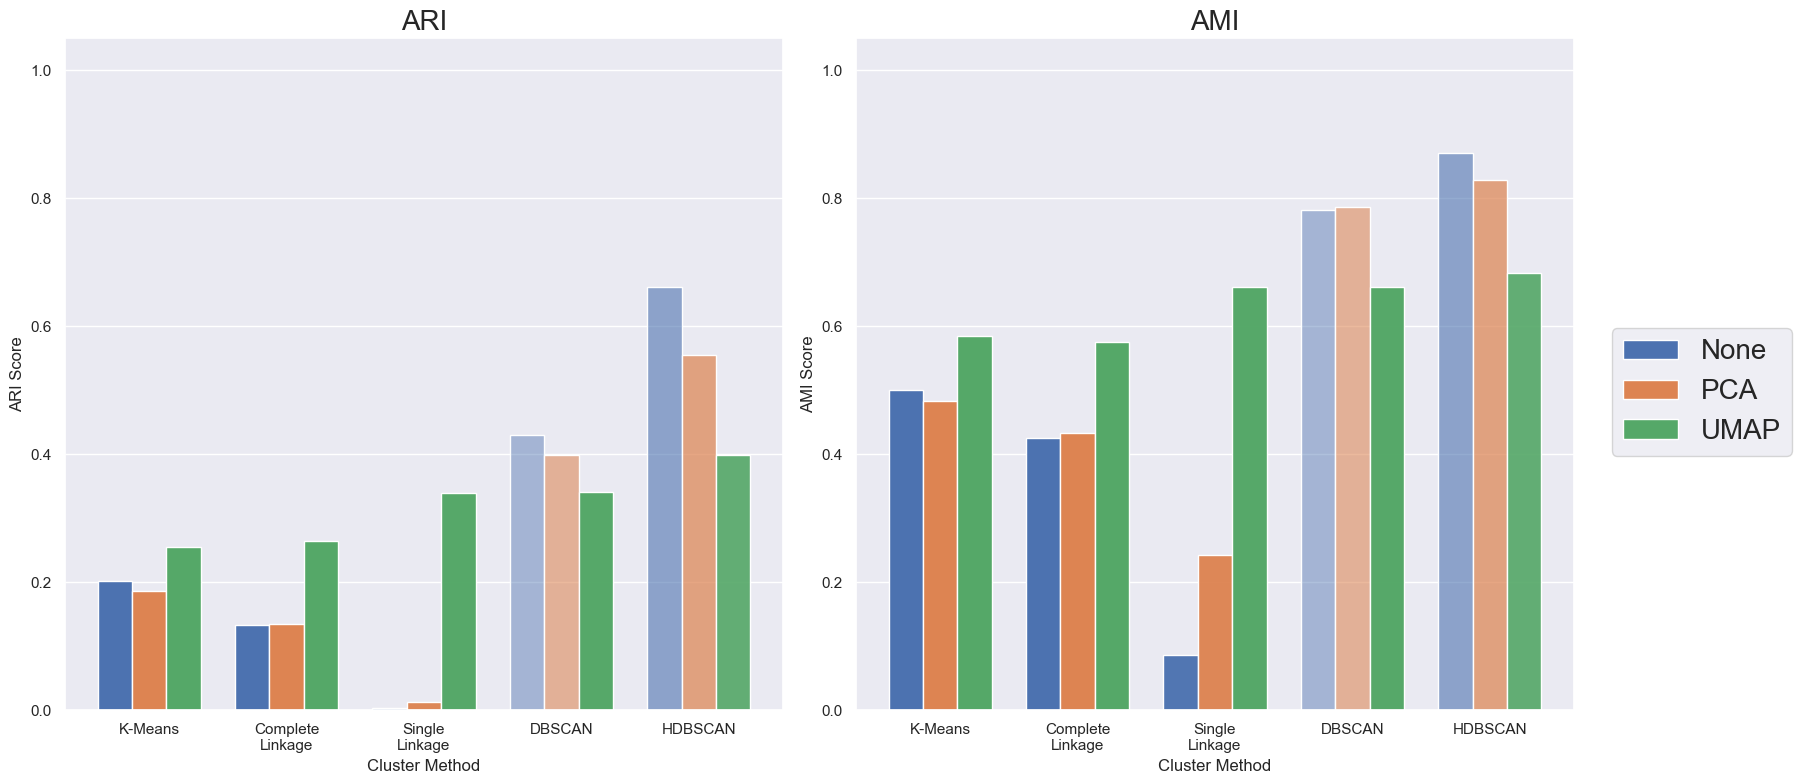

In [82]:
plot_scores(pd.concat([buildings_raw_results_long, buildings_pca_results_long, buildings_umap_results_long]))

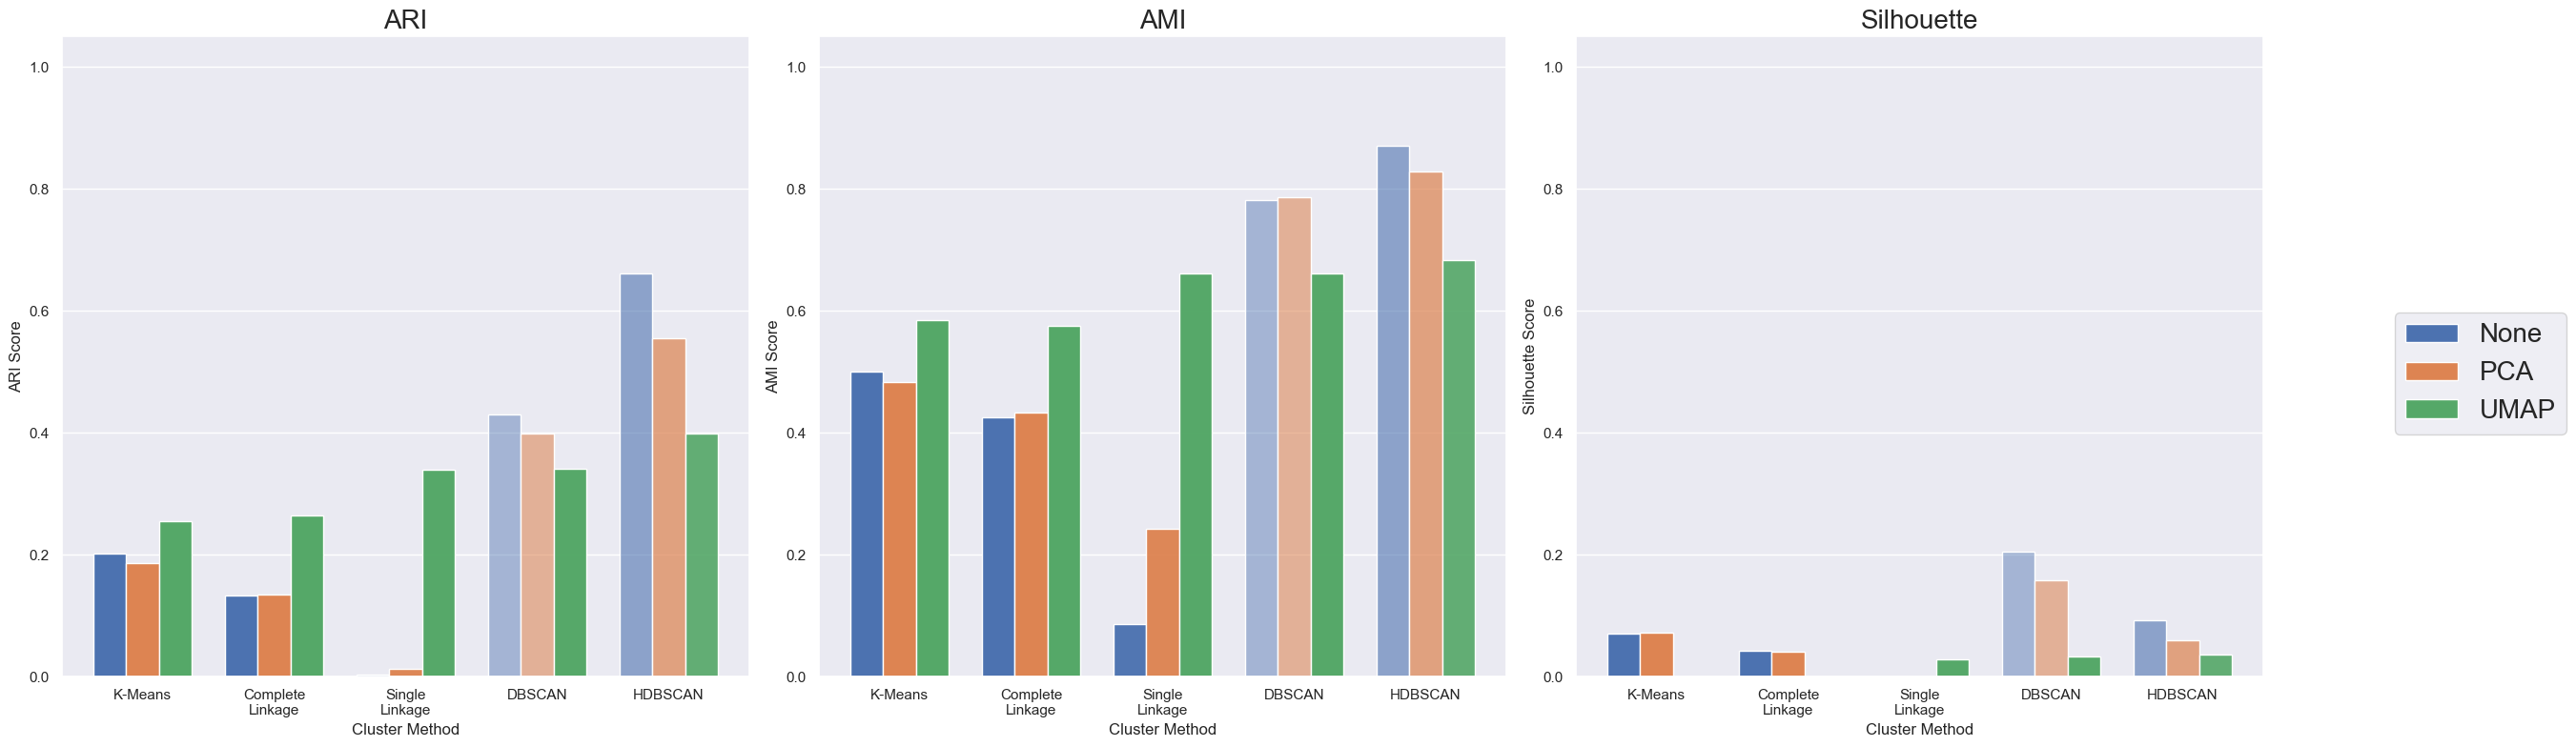

In [83]:
plot_scores(
    pd.concat([buildings_raw_results_long, buildings_pca_results_long, buildings_umap_results_long]),
    score_types=("ARI", "AMI", "Silhouette")
)